# **Credit Card Customer Segmentation**

## **Background**

AllLife Bank (ALB) wants to focus on its credit card customer base in the next financial year. ALB has been advised by its marketing research team (MRT), that the market penetration can be improved. Based on this premise, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the MRT was that customers perceive the support services of ALB poorly. Considering these, the Operations team wants to improve the service delivery model to ensure that customer queries are resolved faster. The head of Marketing and the head of Delivery decide to reach out to the Data Science team for help.

![](https://i.imgur.com/uwk0kPG.jpg)
AI Generated image.

## **Problem Definition**

Credit Card services present these problems:
- Market Penetration has to increase.
- Current Customer's Credit Card Services should increase.
- Credit Card Customer Support is perceived as poor.
- Credit Card Customer's Queries should be resolved faster.


## **Objectives**

1. Identify (classify) the different segments in the existing customer base, based on their spending patterns, past interaction with the bank, and any other important data available.
2. Specify the characteristics of each segment and notice the weak or strong patterns of each segment.
3. Provide recommendations to ALB for each segment based on items 1 and 2 above. These recommendations should include how to expand the market penetration (new and current customers) and how to improve the customer services. Possibly recommend what type of service feature is important for each segment.

## **Data Available**

The data provided is of various customers of ALB and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records

- Customer Key: Customer identification number

- Average Credit Limit: Average credit limit of each customer for all credit cards

- Total credit cards: Total number of credit cards possessed by the customer

- Total visits bank: Total number of visits that customer made (yearly) personally to the bank

- Total visits online: Total number of visits or online logins made by the customer (yearly)

- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## **Questions**

Formulating Questions after knowing what type of data is available help us formulate better questions.

Q1. How can the customers be grouped/segmented (classified)?

Q2. What are the commonalities of each group/segment? ie:
- Total/Particular Interaction w/ ALB
- Total Credit Cards
- Average Credit Limit

Q3. What is the group/segment that has most/least interactions/particular type of interaction with ALB?

Q4. Is there a relationship between Average Credit Limit/Total Credit Cards and customer satisfaction (assuming that the number of interactions is an indication of unsolved issues).

Q5. What is the relationship between Average Credit Limit/Total Credit Cards to interactions/type of interactions with ALB (this question is partially addressed by Q2).

Q6. What recommendations can be made for each group/segment to improve customer satisfaction (assuming that the number of interactions is an indication of unsolved issues).

Q7. What recommendations can be made based in segment characteristics to increase market penetration/expand services to current customers?

With these set of questions, we address the problems introduced earlier and make recommendations to ALB.


## **Technique**

This is a unsupervised classification problem.  We will classify customers into different segments using K-means Clustering and Hierarchical Clustering algorithms.

1. Perform the data preprocessing, EDA analysis, and feature engineering. We will visualize features and observe relationships performing a uni and bivariate analysis.

2. Attempt the classification using the K-means clustering.  We will estimate the better number of clusters using the elbow method and observe silhouettes. Then we will visualize the clusters.  

3. Attempt the classification using the hierarchical clustering.  We will explore clustering with different linkage methods (i.e. single, complete, etc) and distances (i.e. euclidean, manhattan, etc) reviewing the cophenetic correlation and find the ideal number of clusters. Then we will visualize the clusters.

4. Compare K-means vs Hierachical clustering results.


##Setup

In [ ]:
#yellowbrick is a machine learning visualization library. We will use it to
#visualize the cluster silhouettes.
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
#import libraries

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# to round floor, ceil
#from math import floor, ceil

from array import *

#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

#KN clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
import scipy.cluster.hierarchy as shc

from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.decomposition import PCA

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# To impute missing values
#from sklearn.impute import SimpleImputer

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to create k folds of data and get cross validation score
#from sklearn.model_selection import KFold, StratifiedKFold
#from sklearn.model_selection import cross_val_score

# to use standard scaler
from sklearn.preprocessing import StandardScaler

#restrict float value to 3 decimal places
pd.set_option('display.float_format',lambda x: '%.3f' % x)
%matplotlib inline



<IPython.core.display.Javascript object>

In [ ]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

<IPython.core.display.Javascript object>

Mounted at /content/gdrive


In [ ]:
#read csv file and load into a panda dataframe
ALB_orig_df = pd.read_excel('/content/gdrive/MyDrive/UT-ML/Project6/Credit+Card+Customer+Data.xlsx')

<IPython.core.display.Javascript object>

In [ ]:
#copy original data frame
ALB_df = ALB_orig_df.copy()

<IPython.core.display.Javascript object>

## Functions

In [ ]:
#Useful functions for this notebook

#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#function to create histograms and boxplots at once
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

#Function to visualize the clusters using pca
def visualize_clusters(data, number_components, number_clusters):
    """
    data: dataframe
    number_components: the number of components to perform principal component analysis
    number of clusters: how many clusters are visualized
    """
    #set data to number_dimensions
    pca=PCA(number_components)

    #transform the data
    pca_df = pca.fit_transform(data)

    #redo kmeans
    kmeans_pca = KMeans(n_clusters=number_clusters)

    #predict labels
    label = kmeans_pca.fit_predict(pca_df)

    #Get unique labels
    u_labels = np.unique(label)

    #Getting the Centroids
    centroids = kmeans_pca.cluster_centers_

    #plotting the results:

    titleLabel = "Cluster Plot Kn = "+ str(number_clusters)

    plt.title(titleLabel)
    for i in u_labels:
      plt.scatter(pca_df[label == i , 0] , pca_df[label == i , 1] , label = i)
      plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')

    plt.legend()
    plt.show()

#Function to visualize the clusters using pca for hc
def visualize_hc_clusters(data, number_components, number_clusters):
    """
    data: dataframe
    number_components: the number of components to perform principal component analysis
    number of clusters: how many clusters are visualized
    """
    #set data to number_dimensions
    pca=PCA(number_components)

    #transform the data
    pca_df = pca.fit_transform(data)

    #redo hca
    hca_pca = AgglomerativeClustering(n_clusters=number_clusters, affinity="euclidean", linkage="average")
    hca_pca.fit(ALB_scaled_df)

    #predict labels
    label = hca_pca.fit_predict(pca_df)

    #Get unique labels
    u_labels = np.unique(label)

     #plotting the results:

    titleLabel = "Cluster Plot Hierachical Clustering number of clusters = "+ str(number_clusters)

    plt.title(titleLabel)
    for i in u_labels:
      plt.scatter(pca_df[label == i , 0] , pca_df[label == i , 1] , label = i)

    plt.legend()
    plt.show()


#function to plot dendrogram
def plotDendrogram(*Z,leafrotation,colorthreshold,leafontsize):
    """
    *Z: array
    leafrotation: vertical or horizontal
    colorthreshold: colors
    leafontsize: size of font
    """
    plt.figure(figsize=(10, 5))
    plt.title('Agglomerative Hierarchical Clustering Dendogram')
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leafrotation, colorthreshold, leafontsize)
    plt.tight_layout()

def dendrogram_single_plot(data, d_method, d_metric, y_dist):
  plt.figure(figsize=(10, 7))
  title_label = "Dendrogram for method: " + d_method + " metric: "+d_metric +" distance : "+ str(y_dist)
  plt.title(title_label)

  # Selecting method and metric by index
  clusters = shc.linkage(data,
            method=d_method,
            metric=d_metric)
  shc.dendrogram(Z=clusters)
  plt.axhline(y = y_dist, color = 'black', linestyle = '-')

<IPython.core.display.Javascript object>

##**Data Preprocessing**

### **Quick** Analysis

In [ ]:
#Check number of rows and columns
ALB_df.shape

<IPython.core.display.Javascript object>

(660, 7)

660 rows, 7 features

In [ ]:
#Lets take a look at the dataset characteristics
ALB_df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


Notice that there are no null values. Also that all data types are numeric.

In [ ]:
#lets examine the head
ALB_df.head(10)

<IPython.core.display.Javascript object>

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


Notice that out of the 7 features, the first two 'Sl_No' and "Customer Key" are not useful in our analysis. Also notice that the third feature "Avg_Credit_Limit" has values that are very large compared to the rest of the dataset. We anticipate the need to scale the data.

### **Null Values**

In [ ]:
#Checking missing values
ALB_df.isna().sum()

<IPython.core.display.Javascript object>

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

Verifying that there No Nulls.

### **Duplicated entries**

In [ ]:
#Duplicated entries (exact entries or 2 or more rows are exactly the same)
ALB_df.duplicated().sum()

<IPython.core.display.Javascript object>

0

There are no duplicated entries (exact same contents in more than one entry)

In [ ]:
#Duplicated Customers (Customer Key)?
ALB_df['Customer Key'].duplicated().sum()

<IPython.core.display.Javascript object>

5

There are five duplicated customer keys, which represent 0.8% of all data.  Lets check them out.

In [ ]:
ALB_dupKey = ALB_df[ALB_df.duplicated(["Customer Key"], False)]
ALB_dupKey.sort_values(by=['Customer Key'])

<IPython.core.display.Javascript object>

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


The duplicate "Customer Key" may very well be different account snapshots over time. We don't have a time feature but notice that the number of "Total_Credit_Cards" change (and other features changed too). So we consider these different valid entries.

We conclude that there are NO duplicated entries in the data. Even if we drop "Sl_No" and "Customer Key" and we encounter exact duplicated entries, these are valid entries that correspond to different customers or are one of the 5 customers with more than one entry (actually checking the duplicated entries above, we know it is not the case) that represent snapshots of the customer at different times.

Therefore, there are no Duplicate Entries.

###**No Contribution Features**

As we explained earlier, "Sl_No" and "Customer Key" do not contribute any valuable information to our classification (unless of course we choose the number of clusters = number of customers!).

We will drop from our dataset:

- Sl_No: Primary key of the records

- Customer Key: Customer identification number

In [ ]:
#Drop first two columns
coltodrop = ['Sl_No','Customer Key']
ALB_df.drop(coltodrop, axis=1,inplace=True)

In [ ]:
#verify that the columns were dropped
ALB_df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


The features "Sl_No" and "Customer Key" were dropped successfully.

### **Missing Values**

We know that there are no Null values in the data. However, what if there are invalid entries that pose as numbers? Lets check.

In [ ]:
#Check "Avg_Credit_Limit"
ALB_df['Avg_Credit_Limit'].value_counts()

<IPython.core.display.Javascript object>

8000      35
6000      31
9000      28
13000     28
19000     26
          ..
43000      1
146000     1
155000     1
200000     1
167000     1
Name: Avg_Credit_Limit, Length: 110, dtype: int64

In [ ]:
#Check if there is a negative entry for "Avg_Credit_Limit"
AvgCreditNeg = ALB_df[ALB_df['Avg_Credit_Limit']<0]
AvgCreditNeg

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


No negative entries for "Avg_Credit_Limit". The entries are correct.

In [ ]:
#Check "Total_Credit_Cards"
ALB_df['Total_Credit_Cards'].value_counts()

<IPython.core.display.Javascript object>

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64

"Total_Credit_Cards" are all numerical and positive. The entries are valid values.

In [ ]:
#Check "Total_visits_bank"
ALB_df['Total_visits_bank'].value_counts()

<IPython.core.display.Javascript object>

2    158
1    112
0    100
3    100
5     98
4     92
Name: Total_visits_bank, dtype: int64

"Total_visits_bank" are all numerical and positive. The entries are valid values.

In [ ]:
#Check "Total_visits_online"
ALB_df['Total_visits_online'].value_counts()

<IPython.core.display.Javascript object>

2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
10      6
12      6
8       6
11      5
13      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64

"Total_visits_online" are all numerical and positive. The entries are valid values.

In [ ]:
#Check "Total_calls_made"
ALB_df['Total_calls_made'].value_counts()

<IPython.core.display.Javascript object>

4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64

"Total_calls_made" are all numerical and positive. The entries are valid values.

All values are correct, and there are no missing values.

## **EDA**

After treating missing values (none), null values (none), duplicated values (none) and dropping non contributing features, lets check the data again.

In [ ]:
#General statistics of the data
ALB_df.describe().T

<IPython.core.display.Javascript object>

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.000,34574.242,37625.488,3000.000,10000.000,18000.000,48000.000,200000.000
Total_Credit_Cards,660.000,4.706,2.168,1.000,3.000,5.000,6.000,10.000
Total_visits_bank,660.000,2.403,1.632,0.000,1.000,2.000,4.000,5.000
Total_visits_online,660.000,2.606,2.936,0.000,1.000,2.000,4.000,15.000
Total_calls_made,660.000,3.583,2.865,0.000,1.000,3.000,5.000,10.000


- Avg_Credit_Limit values are in a completely different range than the other features.  Its average is \$34,880, minimum is \$3,000, maximum is \$200,000. 25%(Q1) of customers have \$10,000 or less credit and only 25% (Q3) have \$48,000 or more. The median (Q2) is \$18,000.

- Total_Credit_Cards are between 1 to 10, with the mean around 4.7. The maximum is 10 and the minimum is 1. Only 25% (Q3) of customers have 6 or more cc, while 25% (Q1) have 3 cc or less. The median (Q2) is 5.

- Total_visits_bank are between 0 to 5, with a mean of 2.4. The maximum is 5 and the minimum is 0. 25% (Q3) visit the bank 4 or more times, and 25% (Q1) visit the bank 1 or less times. The median (Q2) is 2.

- Total_visits_online are between 0 to 15, with the mean around 2.6.  The maximum is 15 and the minimum is 0.  25% (Q3) visit the online bank 4 or more times, and 25% (Q1) visit the online bank 1 time or less. The median (Q2) is 2.

- Total_calls_made are between 0 to 10, with the mean around 3.6. The maximum is 10 and the minimum is 0. 25% (Q3) make 5 or more calls, and 25% (Q1) make one call or less. The median (Q2) is 3.

Lets see what all this means performing a univariate analysis.

### **Univariate Analysis**

<IPython.core.display.Javascript object>

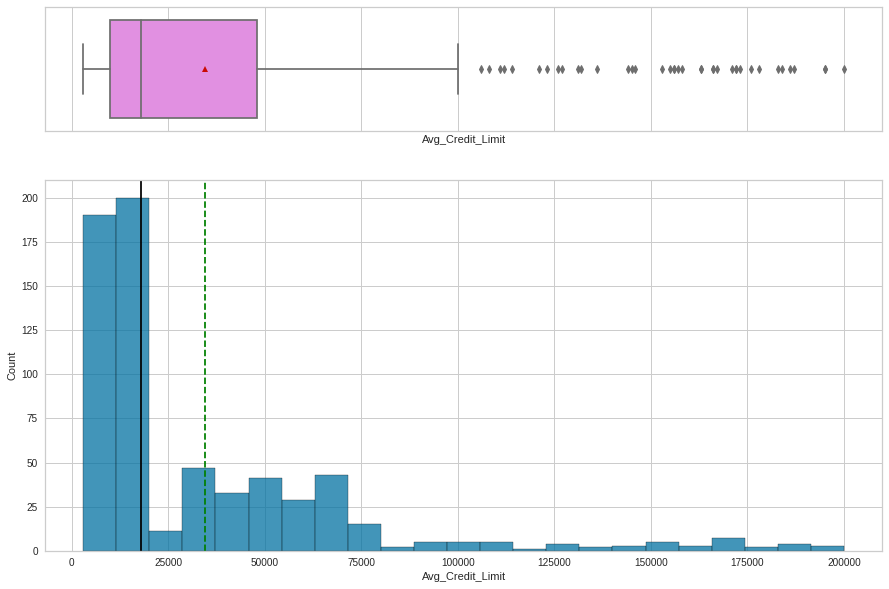

In [ ]:
#Analyze "Avg_Credit_Limit"
histogram_boxplot(ALB_df, "Avg_Credit_Limit")

In [ ]:
acl_median = ALB_df['Avg_Credit_Limit'].median()
print("Avg_Credit_Limit median = ",acl_median)

<IPython.core.display.Javascript object>

Avg_Credit_Limit median =  18000.0


Notice that the distribution is skewed to the right (positively skewed). The median is \$18,000, and the mean is \$34,574. There are many outliers above \$100,000.

Are these outliers valid? In a bank, there will be customers that fall within the range of the outliers. There will be customers that have large average credit limits. Also, notice that this may be related to the number of credit cards a customer has.

75% (Q3) of the data is below \$50,000 and 25% (Q1) of the data is somewhere below \$12,500.

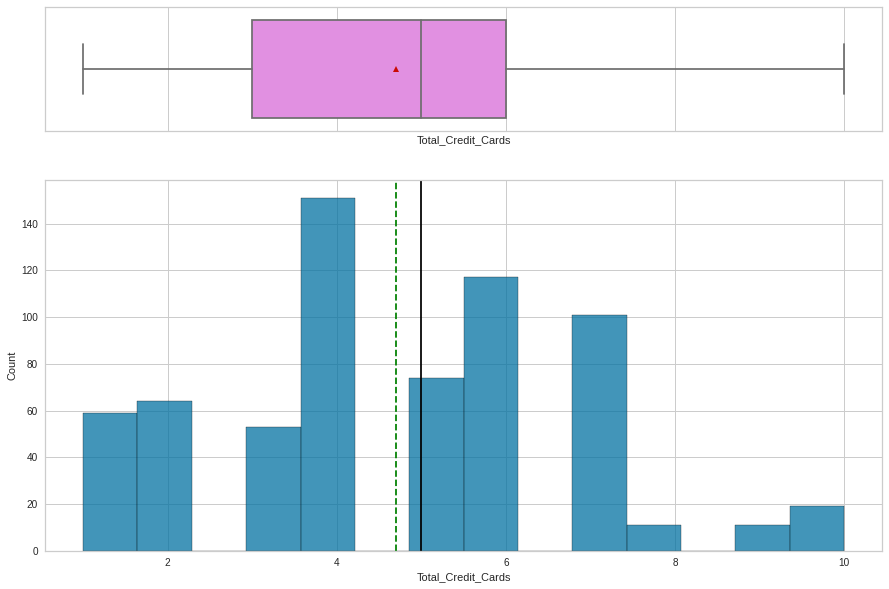

In [ ]:
#Analyze "Total_Credit_Cards"
histogram_boxplot(ALB_df, "Total_Credit_Cards")

In [ ]:
tcc_median = ALB_df['Total_Credit_Cards'].median()
print("Total_Credit_Cards median = ",tcc_median)

<IPython.core.display.Javascript object>

Total_Credit_Cards median =  5.0


"Total_Credit_Cards" is skewed left (negative skew).

The median is 5, the mean is 4.7, 25%(Q1) of the data has 3 cards or less and 25%(Q3) has 6 cards or more.

There are no outliers.

<IPython.core.display.Javascript object>

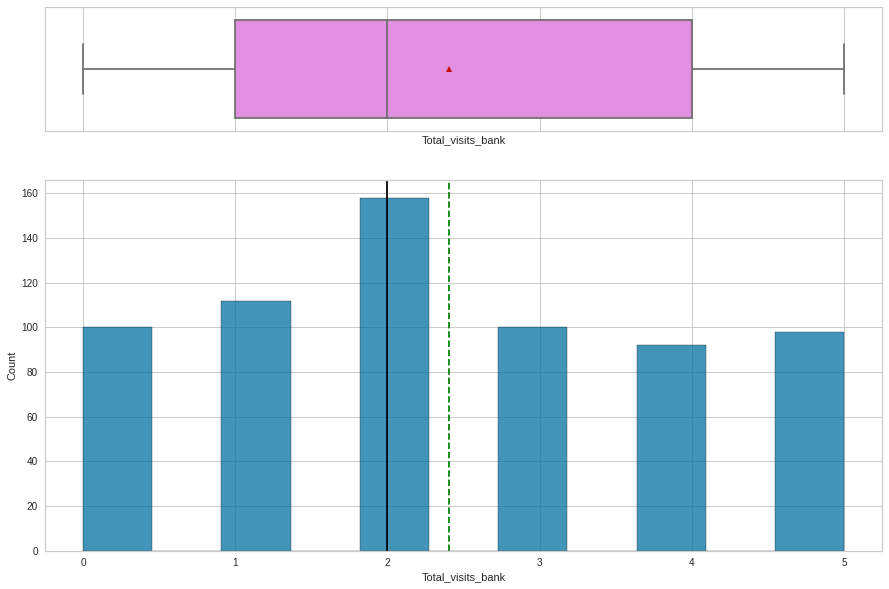

In [ ]:
#Analyze "Total_visits_bank"
histogram_boxplot(ALB_df, "Total_visits_bank")

In [ ]:
tvb_median = ALB_df['Total_visits_bank'].median()
print("Total_visits_bank median = ",tvb_median)

<IPython.core.display.Javascript object>

Total_visits_bank median =  2.0


"Total_visits_bank" is skewed to the right (positive skew).

It has a median of 2 and a mean of 2.4, 25% (Q1) makes 1 visit to the bank or less, and 25% (Q3) makes 4 visits to the bank or more. There are outliers above 8 visits to the bank.

How shoule we treat the outliers? In a bank, there will always be customers that visit the bank many times above the average.

<IPython.core.display.Javascript object>

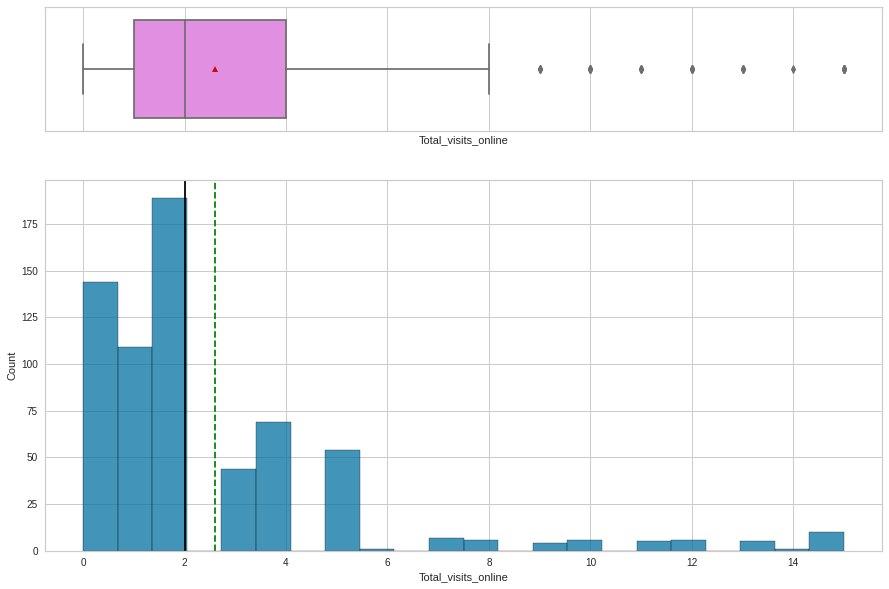

In [ ]:
#Analyze "Total_visits_online"
histogram_boxplot(ALB_df, "Total_visits_online")

In [ ]:
tvo_median = ALB_df['Total_visits_online'].median()
print("Total_visits_online median = ",tvo_median)

<IPython.core.display.Javascript object>

Total_visits_online median =  2.0


"Total_visits_online" is skewed to the right (Positive skew). It has a median of 2 and a mean of about 2.6.

25% (Q1) make 1 visit online or less, and 25% (Q3) make 4 visits online or more.

There are outliers above 8. But a bank will always experience many customers that make countless visits online.


<IPython.core.display.Javascript object>

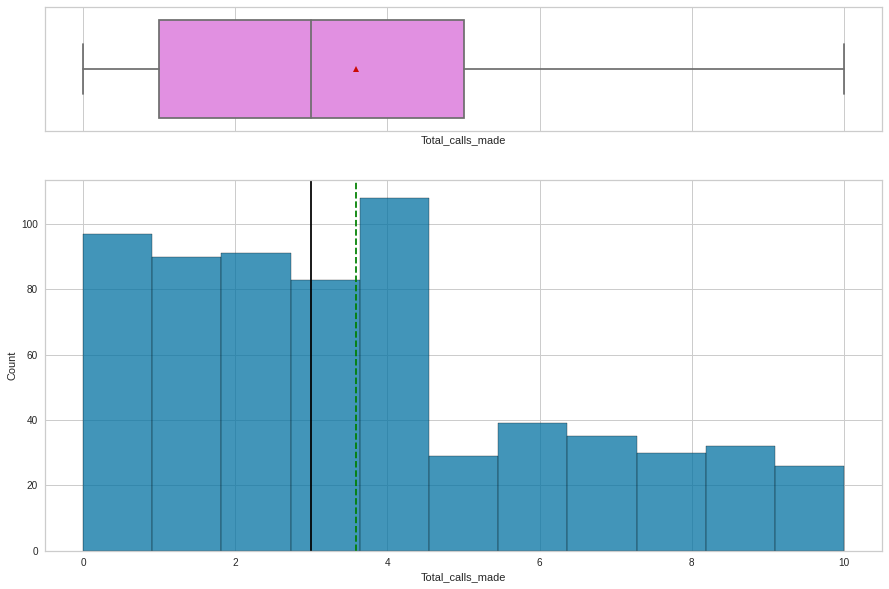

In [ ]:
#Analyze "Total_calls_made"
histogram_boxplot(ALB_df, "Total_calls_made")

In [ ]:
tcm_median = ALB_df['Total_calls_made'].median()
print("Total_calls_made median = ",tcm_median)

<IPython.core.display.Javascript object>

Total_calls_made median =  3.0


This resembles more a normal distribution compared to all other features, and it is skewed to the right.

The median is 3, mean is 3.5, 25%(Q1) make 1 phone call or less, and 25%(Q3) make 5 or more phone calls.

There are no outliers.

<IPython.core.display.Javascript object>

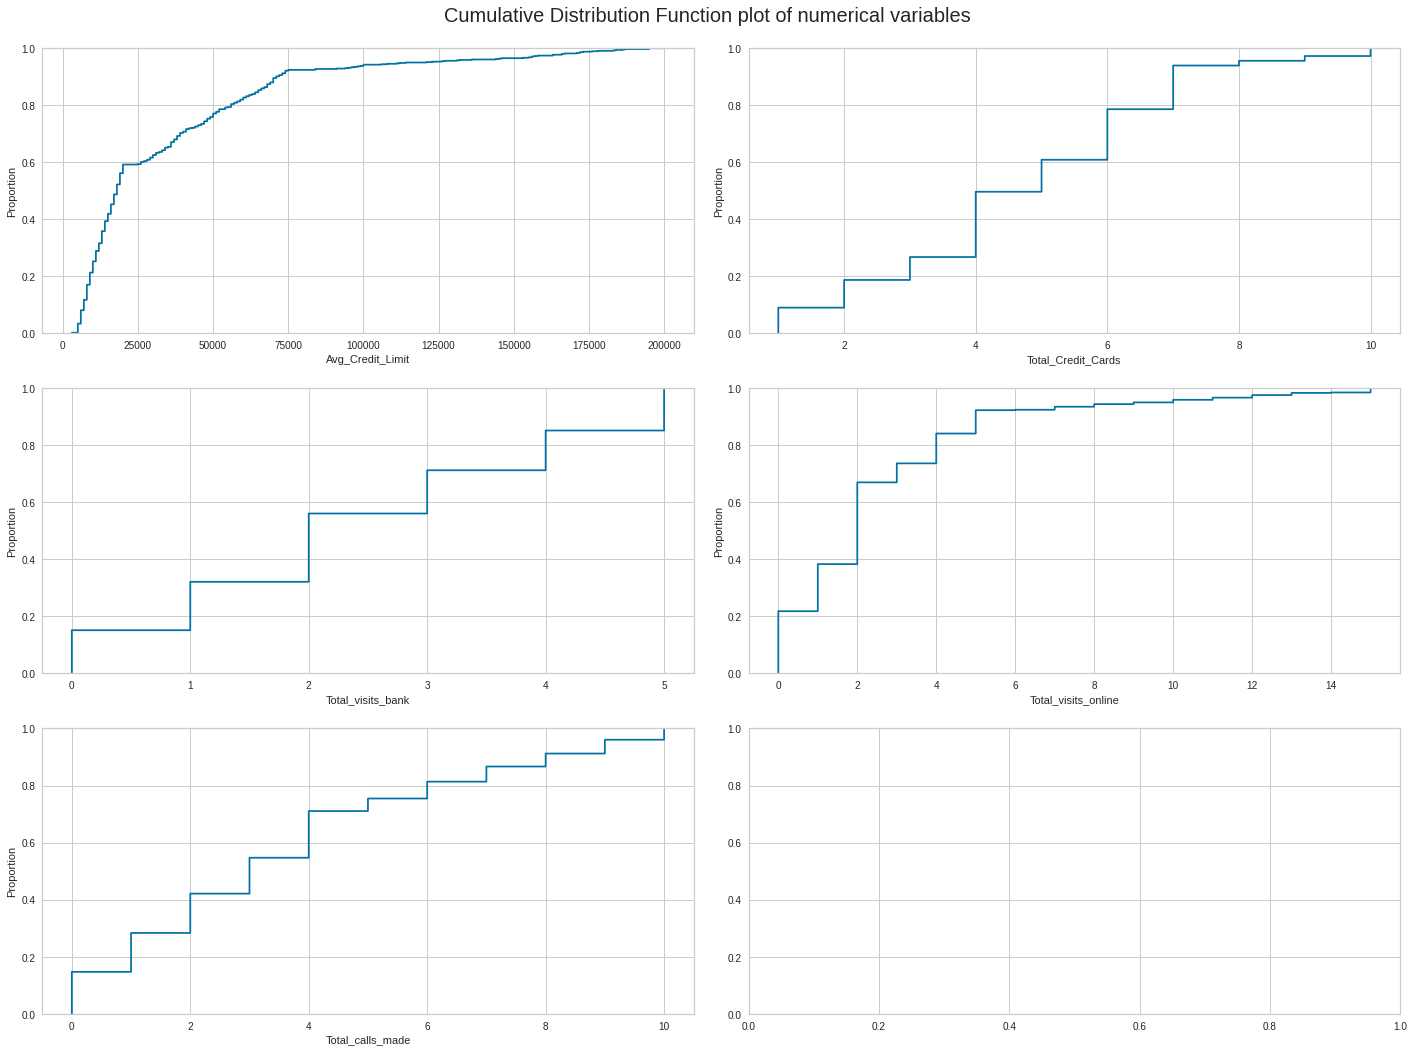

In [ ]:
#make subplots of the general distribution of each feature
num_col = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made']

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("Cumulative Distribution Function plot of numerical variables", fontsize=20)

counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=ALB_df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=ALB_df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

The above subplots are CUMULATIVE distributions.

- 60% of customers have avg credit limit up tp 25,000, and less than 10% have avg credit limit of 75,000 or more.
- Less than 20% of customers have at least 2 cards, around 50% of customers have 4 credit cards or more, and less than 21% have 6 or more.
- More than 40% of customers have at least 2 visits to the bank.
- Around 30% of customers make 4 or more calls to the bank.
- Close to 25% of customers make 2 or more online visits, and about 15% make 4 or more visits.

<IPython.core.display.Javascript object>

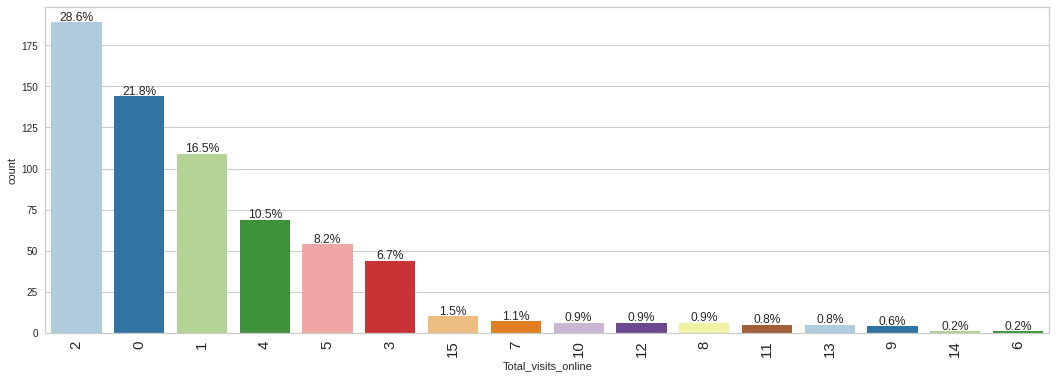

In [ ]:
# let's explore Total_visits_online further
labeled_barplot(ALB_df, "Total_visits_online", perc=True)

- 28.5% of customers do 2 online visits, 21.7% do 0 online visits, 16.5% do 1 online visit, and 25.4% do between 3 to 5.
- Notice that 1.5% do 15 online visits

<IPython.core.display.Javascript object>

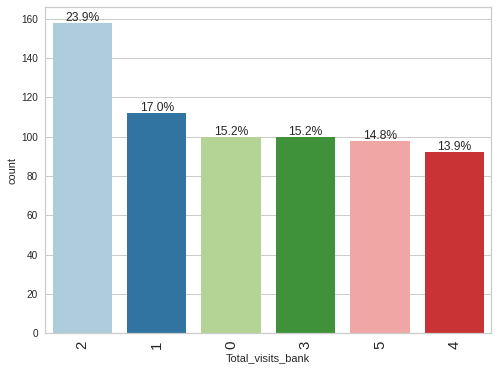

In [ ]:
# let's explore Total_visits_bank further
labeled_barplot(ALB_df, "Total_visits_bank", perc=True)

- 24% do 2 bank visits, being the largest bin.
- 17.3% do 1 bank visit.
- Similarly split around 15%, for a total of 45% of customers, do between 3 to 5 visits.
- 15% do no visits.

<IPython.core.display.Javascript object>

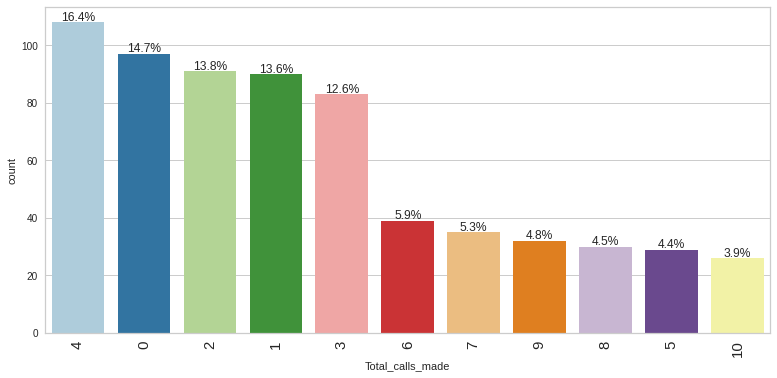

In [ ]:
# let's explore Total_calls_made further
labeled_barplot(ALB_df, "Total_calls_made", perc=True)

- The largest bin 4 calls is 16% of customers.
- 14.8% do 0 calls
- Similarly split are 1, 2, and 3 calls for a total of 41%.
- All others 5 to 10 are between 6% ro 4%.
- Notice that 10 calls are the smaller group and that each bin from from 5 to 10 calls are much smaller than the bin representing 3 calls.
- The majority of customers call between 0 to 4 times.

<IPython.core.display.Javascript object>

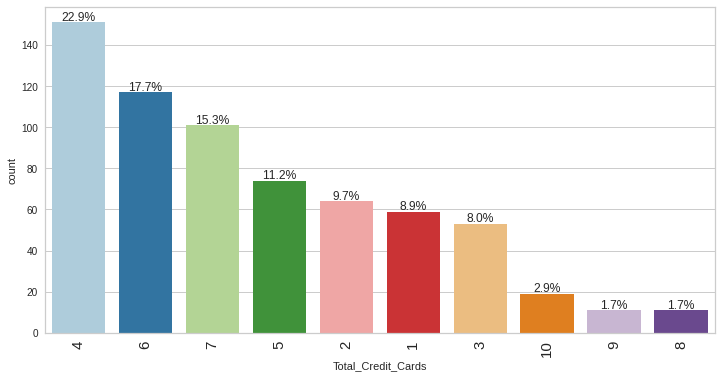

In [ ]:
# let's explore Total_Credit_Cards further
labeled_barplot(ALB_df, "Total_Credit_Cards", perc=True)

- 4 credit cards is the largest bin.
- 10, 9, 8 credit cards are the smallest bins, and they are significantly maller than other bins.
- 4,6,7 are significantly larger than other bins.

### **Outlier Treatment**

We observed during our univariate analysis that outliers represent valid entries for a bank business environment.

If we would drop these outliers we will be not considering these type of customers.

Therefore, we will keep outliers in our data.

## **Bivariate Analysis**

Lets perform a bivariate analysis.

<IPython.core.display.Javascript object>

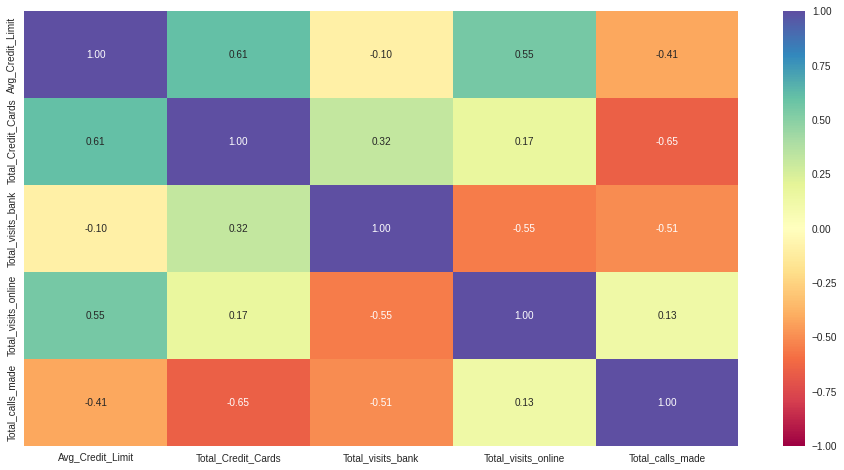

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(ALB_df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Number of Credit Cards vs Contact with the ALB**
- Total_Credit_Cards and Total_calls_made have the highest correlation (-0.65) which may mean that customers that have more cards, make more phone calls to ALB.
- Total_Credit_Cards and Total_visits_online have a correlation of 0.17, among the lowest between all features. So this may mean that without regards of the Total number of credit cards, online communications may not be trusted, or may not be working, or may not provide the service customers require.
- Total_Credit_Cards and Total_visits_bank have a correlation of 0.31, significantly higher than online contacts.

**Type of Contacts vs Other Type of Contacts with ALB**
- Total_visits_online and Total_visits_bank is surprisingly high, with a correlation of 0.55. This may mean that customers that have a high number of online visits end up visiting the bank for whatever reasons, probably because their issue, problem, transaction, etc couldn't be completed online.  Earlier when we were discussing Number of Credit Cards vs Contact with ALB, we noticed the low correlation between Total_visits_online and Total_Credit_Cards.
- Total_calls_made and Total_visits_bank also have a high correlation of 0.5. This may mean that customers that called the bank and didn't solve their issue, transaction, problem, ended up visiting the bank.
- Total_visits_online and Total_calls_made have a correlation of 0.13 which is the second lowest correlation among all features.

**Credit Limit vs Number of Credit Cards
- Total_Credit_Cards and Avg_Credit_Limit have a correlation of 0.61, second highest. This was expected because probably the more credit cards, the larger the credit limit.

**Credit Limit vs Contaacts with ALB
- Total_calls_made and Avg_Credit_Limit have a correlation of 0.42 which is strong but less than Total_Credit_Cards and Total_calls_made (0.65). This may mean that more calls are made due to the number of credit cards than due to a larger credit limit.
- Total_visits_oline and Avg_Credit_Limit has a high correlation of 0.55. This may mean that a higher credit limit means that customer may make more online visits.
- Total_visits_bank and Avg_Credit_Limit has a correlation of 0.10, which is the lowest of all. This may mean that afterall, most customers with higher credit limit solved their problems, issues with other types of communications (calls or online).

<IPython.core.display.Javascript object>

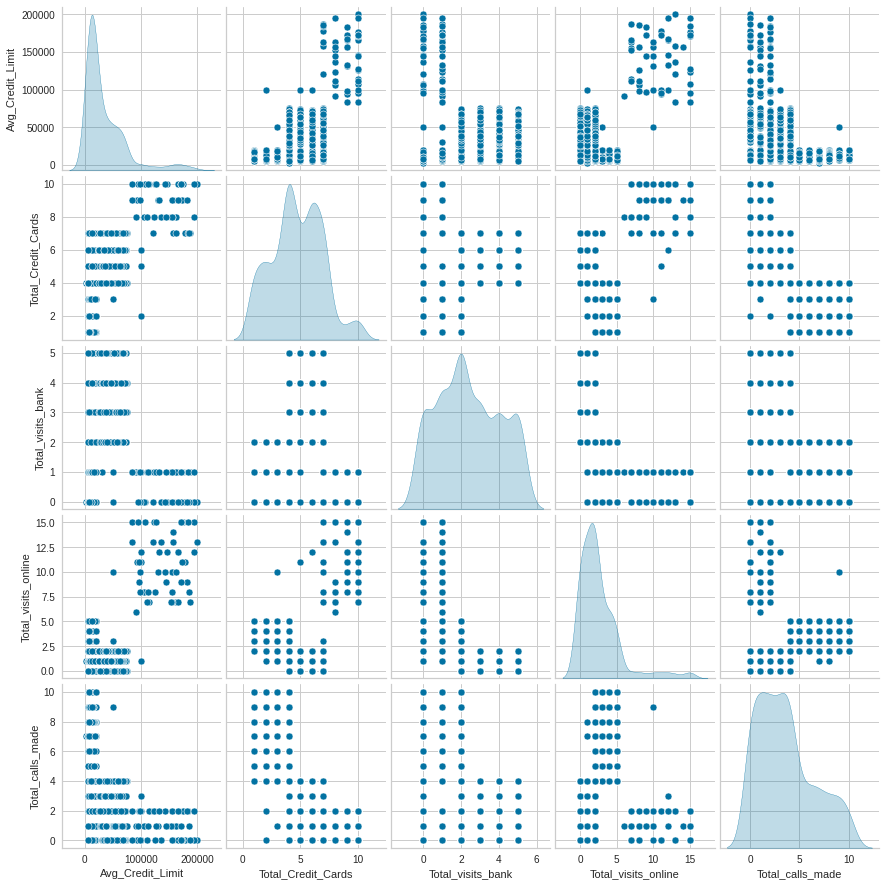

In [ ]:
#visualize pair plots
sns.pairplot(data=ALB_df[num_col], diag_kind="kde")
plt.show()

Many interesting things can be observed from the pairplots above to compliment the observations made from the heatmap shown before.
- As expected, most customers have lower credit limits and there are only a few that have higher credit limits. However, those outliers are valid because in any bank there will be banks with extraordinary credit limits, more so in this case where many customers have several credit cards.
- Customers with the highest avg credit limits have consistently more credit cards between 5 to 10.
- Customers that visit the bank less have higher credit limit. Is this because the bank gives them more importance?
- Customers with higher credit limits consistently do more online visits than customers with lower credit limits.
- consistently customers call the bank between 0 to 3 times.

Notice that it is difficult to guess the number of clusters from the pairplots because the plots are not very similar. For example Avg_Credit_Limit may hint 3 clusters, but Total_Credit_Cards may hint 4 clusters. Then Total_visits_bank may hint 6 clusters, Total_visits_online may hint 4 clusters, and Total_calls_made may hint 3 clusters.

## **Data Arrangement for Classification**

In [ ]:
#variables used for clustering
num_col

<IPython.core.display.Javascript object>

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

**Scaling Data**

In [ ]:
# scaling the dataset before clustering
scaler = StandardScaler()

#make a copy of the previously processed data. Keep in mind then:
#ALB_orig_df is the original data
#ALB_df is the processed data treated against duplicates, null values, missing values,
#dropped features before scaling
#ALB_scaled is the scaled dataset

ALB_scaled = scaler.fit_transform(ALB_df)

<IPython.core.display.Javascript object>

In [ ]:
# creating a dataframe of the scaled columns
ALB_scaled_df = pd.DataFrame(ALB_scaled, columns=ALB_df.columns)

<IPython.core.display.Javascript object>

In [ ]:
#The scaled data
ALB_scaled_df.head(10)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740,-1.249,-0.860,-0.547,-1.252
1,0.410,-0.788,-1.474,2.521,1.892
2,0.410,1.059,-0.860,0.134,0.146
3,-0.122,0.136,-0.860,-0.547,0.146
4,1.740,0.597,-1.474,3.202,-0.204
5,-0.388,-0.788,-1.474,-0.547,1.543
6,1.740,0.136,-1.474,2.861,-0.553
7,-0.521,-0.788,-1.474,-0.547,-0.902
8,-0.787,-1.249,-1.474,-0.207,-0.553
9,-0.840,-0.326,-1.474,-0.547,1.193


So what happens if we use zscore instead of StandardScaler()?

In [ ]:
#Lets apply(zscore) to check the difference with StandardScaler()
ALB_scaled_z_df =ALB_df.apply(zscore)
ALB_scaled_z_df.head(10)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740,-1.249,-0.860,-0.547,-1.252
1,0.410,-0.788,-1.474,2.521,1.892
2,0.410,1.059,-0.860,0.134,0.146
3,-0.122,0.136,-0.860,-0.547,0.146
4,1.740,0.597,-1.474,3.202,-0.204
5,-0.388,-0.788,-1.474,-0.547,1.543
6,1.740,0.136,-1.474,2.861,-0.553
7,-0.521,-0.788,-1.474,-0.547,-0.902
8,-0.787,-1.249,-1.474,-0.207,-0.553
9,-0.840,-0.326,-1.474,-0.547,1.193


As you can see above, using StandardScaler or apply(zscore) both scale the data equally (actually StandardScaler applies zscore).

Keep in mind:

\begin{align}
Z = \frac{(X-\mu)}{\sigma}\end{align}

In [ ]:
ALB_scaled_df.describe().T

<IPython.core.display.Javascript object>

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.000,0.000,1.001,-0.840,-0.654,-0.441,0.357,4.400
Total_Credit_Cards,660.000,0.000,1.001,-1.711,-0.788,0.136,0.597,2.444
Total_visits_bank,660.000,-0.000,1.001,-1.474,-0.860,-0.247,0.979,1.593
Total_visits_online,660.000,0.000,1.001,-0.888,-0.547,-0.207,0.475,4.225
Total_calls_made,660.000,-0.000,1.001,-1.252,-0.902,-0.204,0.495,2.241


statistics after normalizing the data.

## **K-means Classification Modeling**

Using K-means algorithm, we will cluster the data by trying to separate samples in groups of equal variance, minimizing the intra-cluster square errors, that is minimizing the within-cluster sum-of-squares.



### **Elbow curve method**

Using the elbow curve to guess the number of clusters.

<IPython.core.display.Javascript object>

Number of Clusters: 1 	Average Distortion: 2.006922226250361
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9094246068442045
Number of Clusters: 8 	Average Distortion: 0.8887065275494689
Number of Clusters: 9 	Average Distortion: 0.8632252907059607


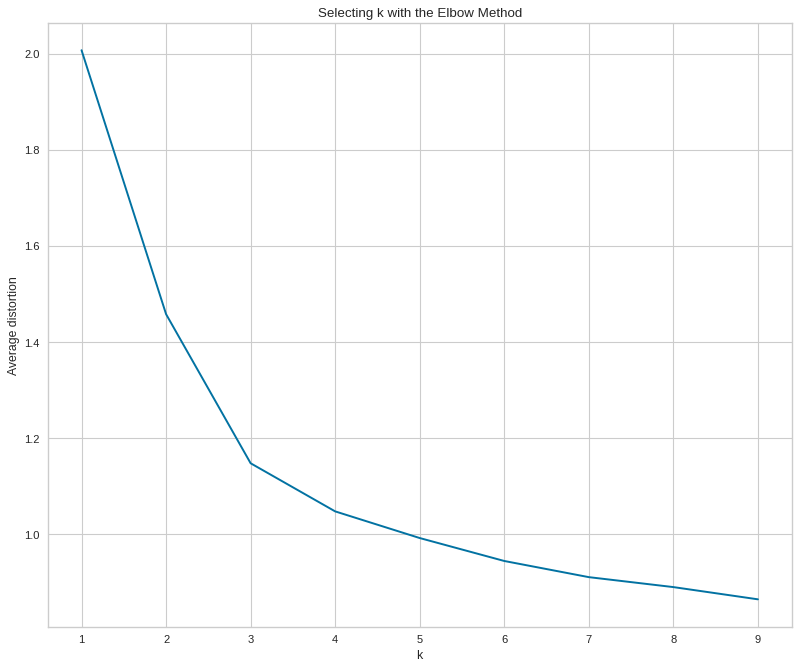

In [ ]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(ALB_scaled_df)
    prediction = model.predict(ALB_scaled_df)
    distortion = (
        sum(
            np.min(cdist(ALB_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / ALB_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)
plt.figure(figsize=(12, 10), dpi=80)
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

Notice sharp bents at 2, 3, 4, 6, and 7. The bent as 3 looks the most relevant.


### **Silhouette scores**

The silhouette scores are computed as follows:

\begin{align}
Silhouette Score = \frac{(b-a)}{max(a,b)}\end{align}

where

b: mean nearest-cluster distance (distance between a sample and the nearest cluster that the sample is not a part of).

a: mean intra-cluster distance

<IPython.core.display.Javascript object>

For n_clusters = 2, the silhouette score is 0.41842496663215445)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3556670619372605)
For n_clusters = 5, the silhouette score is 0.2717470361089752)
For n_clusters = 6, the silhouette score is 0.25516863727620004)
For n_clusters = 7, the silhouette score is 0.24809453254847574)
For n_clusters = 8, the silhouette score is 0.22736445234896802)
For n_clusters = 9, the silhouette score is 0.2217203577993332)


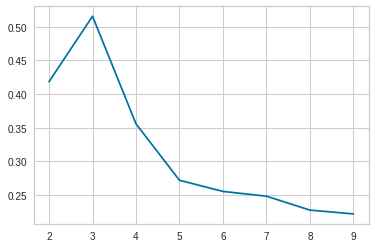

In [ ]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((ALB_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(ALB_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

The silhouette score for n_clusters= 3 clusters is 0.516. The silhouette score for n_clusters= 4 is 0.357. The silhouette score for n_clusters= 2 is 0.418.

A high silhouette score is an indication of how dense the clusters are, so we are looking for values closer to 1 (and farther from -1 which represents a completely incorrect cluster). The associated n_cluster should be an ideal k value.

So in this case, k =3 has the highest silhouette score so we will begin by considering k=3 and later compare to the next Ks with the highest silhouette scores (2 and 4).

**Visualize the Clusters silhouettes**

<IPython.core.display.Javascript object>

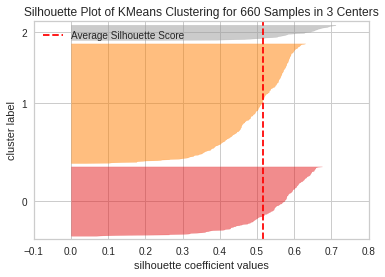

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients k=3
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(ALB_scaled_df)
visualizer.show()

The average silhouette score for K=3 is somewhere around 0.52.

For K=3 clusters 0, 1, and 2 are within the average silhouette score, being cluster 2 the most cohesive and cluster 0 being more cohesive than cluster 1.

Overall, the 3 clusters are balanced.


<IPython.core.display.Javascript object>

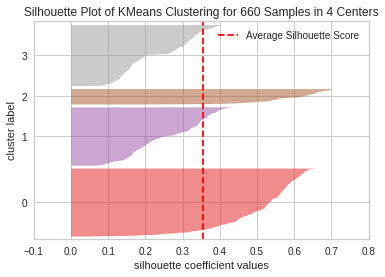

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients k=4
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(ALB_scaled_df)
visualizer.show()

The average silhouette score for K=4 is somewhere around 0.36.

For K=4 clusters 0, 1, 2, and 3 are within the average silhouette score, being cluster 2 the most cohesive and cluster 0 being more cohesive than cluster 1 and 3.

However the plot shows cluster imbalance as we can see that clusters 1 and 3 have signficantly narrower plots than clusters 2 and 4.


<IPython.core.display.Javascript object>

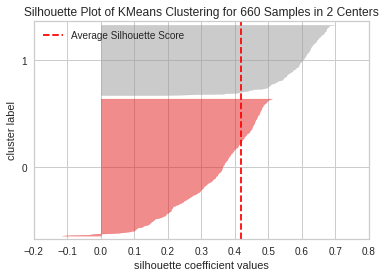

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# finding optimal no. of clusters with silhouette coefficients k=2
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(ALB_scaled_df)
visualizer.show()

The average silhouette score for K=2 is somewhere around 0.42.

For K=2 clusters 0 and 1 are within the average silhouette score, being cluster 0 the most cohesive.

Overall, the two clusters are not well balanced as we can see that cluster 0 is much wider than cluster 1.

Comparing the three silhouette plots for K=2, 3, and 4, although the clusters in each K fall within the average silhouette scores, the plot for K=3 shows clusters that are better balanced.


In [ ]:
#since we are going to compare our results for different ks, lets make different
#dataframes for each k
ALB_k3_df = ALB_df.copy()
ALB_scaled_k3_df = ALB_scaled_df.copy()

ALB_k4_df = ALB_df.copy()
ALB_scaled_k4_df = ALB_scaled_df.copy()

ALB_k2_df = ALB_df.copy()
ALB_scaled_k2_df = ALB_scaled_df.copy()


<IPython.core.display.Javascript object>

### **Cluster profiling**

Note: We may be referring to Clusters as Segments or Groups within this notebook.

**K=3 Clusters**

In [ ]:
# let's take 3 as number of clusters
kmeans_k3 = KMeans(n_clusters=3, random_state=1)
kmeans_k3.fit(ALB_scaled_k3_df)
prediction_k3 = kmeans_k3.predict(ALB_scaled_k3_df)

In [ ]:
# adding kmeans cluster labels to the original and scaled dataframes
ALB_k3_df["SEGMENT"] = prediction_k3
ALB_scaled_k3_df["SEGMENT"] = prediction_k3
print("SEGMENTS Assigned : \n")
ALB_k3_df.head(20)

<IPython.core.display.Javascript object>

SEGMENTS Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,SEGMENT
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [ ]:
#Averages for each feature when k=3
cluster_profile_k3 = ALB_k3_df.groupby("SEGMENT").mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

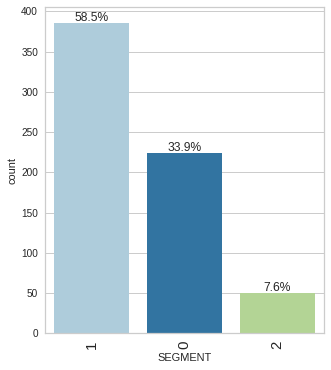

In [ ]:
#plot counts for each segment
labeled_barplot(ALB_scaled_k3_df, "SEGMENT", perc=True, n=None)

58% of customers are clustered in Segment 1, only 7.7% are clustered in Segment 2.

In [ ]:
cluster_profile_k3["count_in_each_segments"] = (
    ALB_k3_df.groupby("SEGMENT")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# let's display cluster profiles
cluster_profile_k3.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
SEGMENT,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


Notice that cluster 2 has the highest average credit limit, the highest average total credit cards and the highest average total visits online. Also, it has the lowest total visits bank, the lowest total calls made and it is the smallest cluster with 50 points.

Cluster 1 has the largest total visits bank and it is the largest cluster. It has the second largest Avg_Credit_Limit and the second largest Total_Credit_Cards.

Cluster 0 has the largest total calls made, the smallest Avg_Credit_Limit and the smallest Total_Credit_Cards. It is the second largest group.

So would Segment 2 be ALB "Super VIP", Segment 1 be "VIP" and Segment 0 be "Standard" customers?

<IPython.core.display.Javascript object>

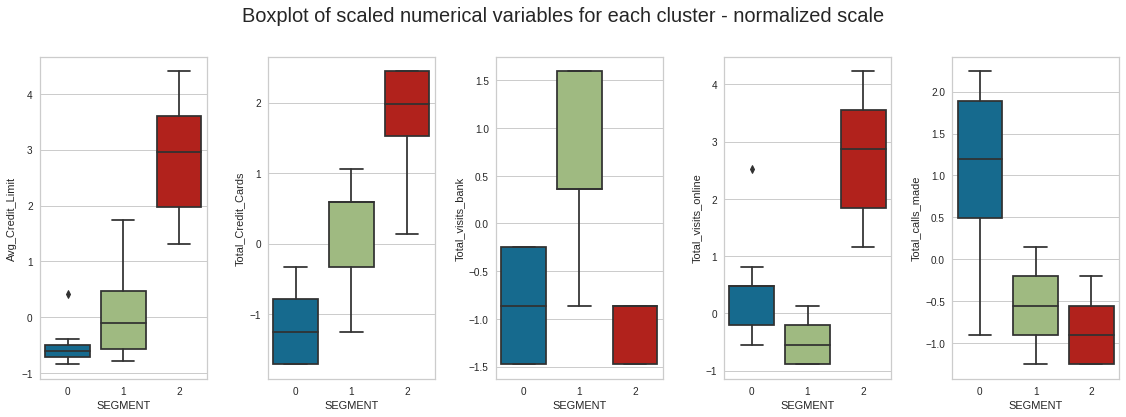

In [ ]:
#visualize the boxplots for each segment for each feature for the scaled data.
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster - normalized scale", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ALB_scaled_k3_df[num_col[counter]],
        x=ALB_scaled_k3_df["SEGMENT"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)


Notice that when k=3, segments for Total_Credit_Cards, Total_visits_online and Avg_Credit_Limit are clearly separated.

Total_visits_bank is not separated between Segment 0 and 2, but segment 1 is well separated. In fact, segment 0 contain all the values present in segment 0.

Total_calls_bank segment 0 is separated well from segment 1 and 2, but segment 1 and 2 have values in common.

<IPython.core.display.Javascript object>

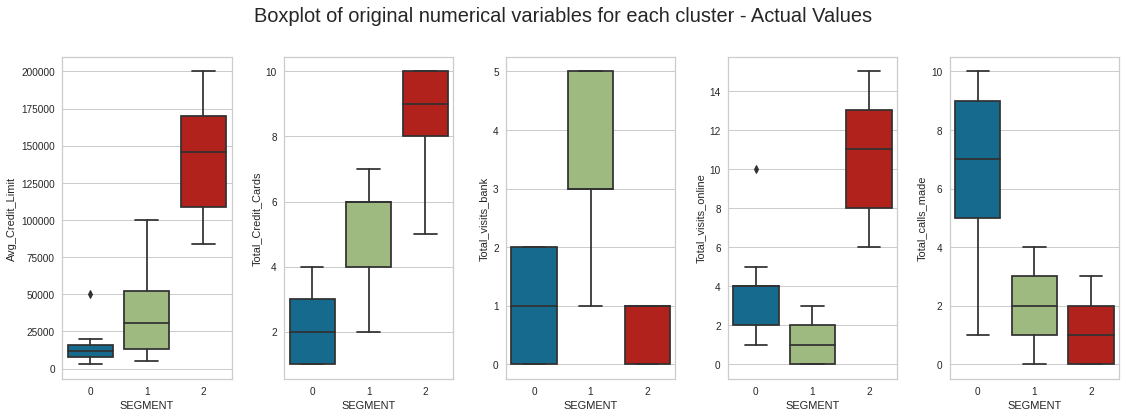

In [ ]:
#visualize the boxplots for each segment for each feature for the data represented
#with actual values.
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster - Actual Values", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=ALB_k3_df[num_col[counter]], x=ALB_k3_df["SEGMENT"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

The plot above is actually the same plot for normalized values, but the values shown are the actual values.

In [ ]:
#crosstable for Total_Credit_Cards per segment
pd.crosstab(ALB_k3_df.SEGMENT, ALB_k3_df.Total_Credit_Cards).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_Credit_Cards,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,
0,59,63,53,49,0,0,0,0,0,0
1,0,1,0,102,73,116,94,0,0,0
2,0,0,0,0,1,1,7,11,11,19


Notice that segment 0 is between 1 to 3 cards, Segment 1 is between 4 and 7 cards, and Segment 3 between 8 and 10 cards.

We can see that in general, the segments are very well separated as we had already concluded from the Total_Credit_Cards boxplot.

In [ ]:
#Cross table for Avg_Credit_Limit per segment
pd.crosstab(ALB_k3_df.SEGMENT, ALB_k3_df.Avg_Credit_Limit).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Avg_Credit_Limit,3000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,25000,26000,27000,28000,29000,30000,31000,32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,43000,44000,45000,46000,47000,48000,49000,50000,51000,52000,54000,55000,56000,57000,58000,59000,60000,61000,62000,63000,64000,65000,66000,67000,68000,69000,70000,71000,72000,73000,74000,75000,84000,91000,94000,95000,96000,97000,98000,99000,100000,106000,108000,111000,112000,114000,121000,123000,126000,127000,131000,132000,136000,144000,145000,146000,153000,155000,156000,157000,158000,163000,166000,167000,171000,172000,173000,176000,178000,183000,184000,186000,187000,195000,200000
SEGMENT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,13,17,13,20,18,14,15,8,18,14,11,13,13,9,13,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,8,14,11,15,10,12,9,10,10,9,6,9,10,14,13,7,1,5,2,3,5,6,5,2,4,6,2,11,6,8,7,3,6,2,1,3,3,3,6,6,4,7,4,6,4,1,7,3,3,4,5,3,3,2,4,5,4,3,7,4,10,4,3,4,6,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,2,1,1,2,1,1,1,1,1,1,1,2,1


The above cross table is too large to be visualized in our output. Therefore, lets flip the axis.

In [ ]:
#crosstable for Avg_Credit_Limit for each segment
pd.crosstab(ALB_k3_df.Avg_Credit_Limit, ALB_k3_df.SEGMENT).style.highlight_max(
    color="darkgreen", axis=1
)

<IPython.core.display.Javascript object>

SEGMENT,0,1,2
Avg_Credit_Limit,,,
3000,1,0,0
5000,13,8,0
6000,17,14,0
7000,13,11,0
8000,20,15,0
9000,18,10,0
10000,14,12,0
11000,15,9,0
12000,8,10,0


Consistently, higher avg credit limits above \$84,000 are grouped in Segment 2. Segment 1 consistently has the avg credit limit between \$25,000 to \$75,000 but also contain lower avg credit limits that make up cluster 0.

In [ ]:
#crosstable for Total_visits_bank per segment
pd.crosstab(ALB_k3_df.SEGMENT, ALB_k3_df.Total_visits_bank).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_bank,0,1,2,3,4,5
SEGMENT,,,,,,
0,80,79,65,0,0,0
1,0,3,93,100,92,98
2,20,30,0,0,0,0


Segment 1 is mostly well separated from the other segments. Segment 2 values are also in Segment 1. So segment 2 and 1 are not well separated.

In [ ]:
#cross table for Total_visits_online per segment
pd.crosstab(ALB_k3_df.SEGMENT, ALB_k3_df.Total_visits_online).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
SEGMENT,,,,,,,,,,,,,,,,
0,0,3,54,43,69,54,0,0,0,0,1,0,0,0,0,0
1,144,106,135,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10


Segments are separted very well. Notice that Segment 2 is perfectly separated from the Segment 0 and 1.

In [ ]:
# Cross table for Total_calls_made per segment
pd.crosstab(ALB_k3_df.SEGMENT, ALB_k3_df.Total_calls_made).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_calls_made,0,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,,
0,0,1,1,0,31,29,39,35,30,32,26
1,81,74,72,82,77,0,0,0,0,0,0
2,16,15,18,1,0,0,0,0,0,0,0


Segment 0 is well separated from the other segments. However, Segment 1 and 2 are not well separated.

**Visualize the Clusters k = 3**

<IPython.core.display.Javascript object>

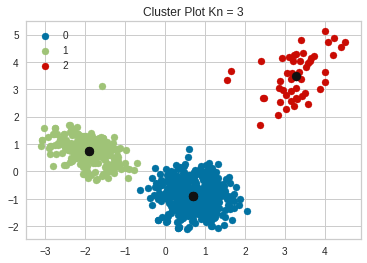

In [ ]:
#Function to visualize the clusters using pca
#PCA is done inside the visualize_clusters function (Refer to the section FUNCTIONS
#to see how this was implemented)

visualize_clusters(ALB_scaled_k3_df, 5, 3)

Overall, when K=3, the clusters are well separated.

We also know how the Cluster Profile is when K=3.

**K=4 Clusters**

Lets see what happens when K=4 was chosen instead. We will not comment every result but focus on the cluster plot. We have seen in the silhouette plot that K=4 has clusters that are less balanced than the case for K=3. We already know that the silhouette score for K=4 is less than the silhouette score for K=3.

In [ ]:
# let's take 4 as number of clusters
kmeans_k4 = KMeans(n_clusters=4, random_state=1)
kmeans_k4.fit(ALB_scaled_k4_df)
prediction_k4 = kmeans_k4.predict(ALB_scaled_k4_df)

<IPython.core.display.Javascript object>

In [ ]:
# adding kmeans cluster labels to the original and scaled dataframes
ALB_k4_df["SEGMENT"] = prediction_k4
ALB_scaled_k4_df["SEGMENT"] = prediction_k4
print("SEGMENTS Assigned : \n")
ALB_k4_df.head(20)

<IPython.core.display.Javascript object>

SEGMENTS Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,SEGMENT
0,100000,2,1,1,0,3
1,50000,3,0,10,9,0
2,50000,7,1,3,4,3
3,30000,5,1,1,4,3
4,100000,6,0,12,3,2
5,20000,3,0,1,8,0
6,100000,5,0,11,2,2
7,15000,3,0,1,1,3
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [ ]:
#create a cluster profile
cluster_profile_k4 = ALB_k4_df.groupby("SEGMENT").mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

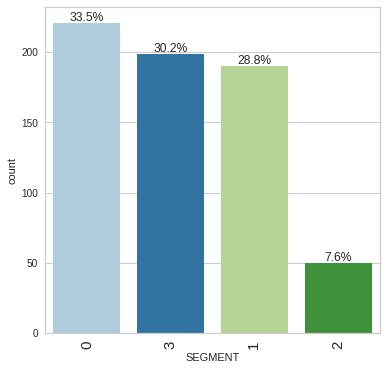

In [ ]:
#plot counts for each segment
labeled_barplot(ALB_scaled_k4_df, "SEGMENT", perc=True, n=None)

In [ ]:
#Group the segments
cluster_profile_k4["Segment_Count"] = (
    ALB_k4_df.groupby("SEGMENT")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# let's display cluster profiles
cluster_profile_k4.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Segment_Count
SEGMENT,,,,,,
0,12167.420814,2.393665,0.927602,3.574661,6.923077,221
1,31226.315789,5.478947,4.515789,1.010526,1.936842,190
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,35904.522613,5.522613,2.477387,0.969849,2.075377,199


<IPython.core.display.Javascript object>

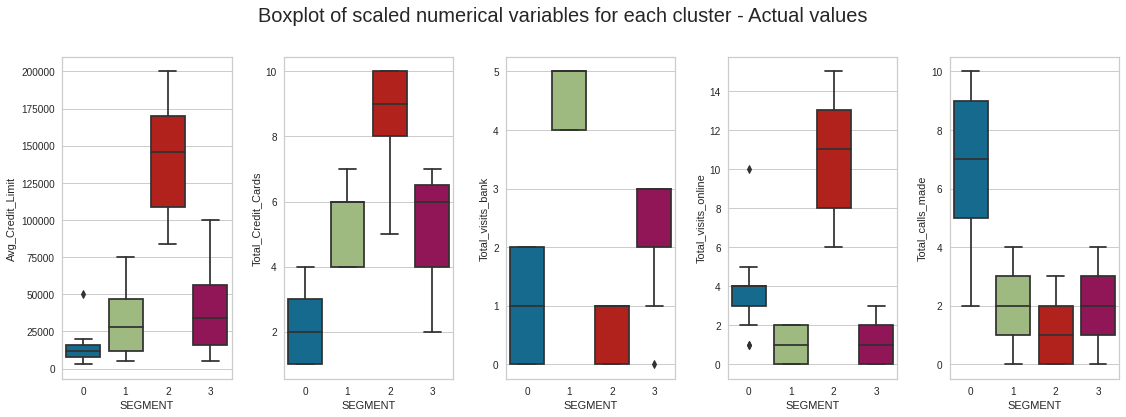

In [ ]:
#visualize the boxplots for each segment and feature
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster - Actual values", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ALB_k4_df[num_col[counter]],
        x=ALB_k4_df["SEGMENT"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

Notice that the boxplots for K=4 aren't as well separated as for K=3.

In [ ]:
#Crosstable Avg_Credit_Limt per segments
pd.crosstab(ALB_k4_df.Avg_Credit_Limit, ALB_k4_df.SEGMENT ).style.highlight_max(
    color="darkgreen", axis=1
)

<IPython.core.display.Javascript object>

SEGMENT,0,1,2,3
Avg_Credit_Limit,,,,
3000,1,0,0,0
5000,13,4,0,4
6000,17,5,0,9
7000,12,7,0,5
8000,20,7,0,8
9000,18,9,0,1
10000,14,8,0,4
11000,15,5,0,4
12000,8,6,0,4


Segment 1 and 4 are not well separated.

In [ ]:
#Crosstable Total_Credit_cards per segments
pd.crosstab(ALB_k4_df.SEGMENT, ALB_k4_df.Total_Credit_Cards).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_Credit_Cards,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,
0,59,63,52,47,0,0,0,0,0,0
1,0,0,0,55,33,58,44,0,0,0
2,0,0,0,0,1,1,7,11,11,19
3,0,1,1,49,40,58,50,0,0,0


Segment 1 and 2 are not well separated.

In [ ]:
#Total_Visits_bank per segment
pd.crosstab(ALB_k4_df.SEGMENT, ALB_k4_df.Total_visits_bank).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_bank,0,1,2,3,4,5
SEGMENT,,,,,,
0,79,79,63,0,0,0
1,0,0,0,0,92,98
2,20,30,0,0,0,0
3,1,3,95,100,0,0


Segment 1 is well separated from all other Segments. Segment 0 and 2 are not well separated and Separated from Segment 0.

In [ ]:
#Total_visits_online per segment
pd.crosstab(ALB_k4_df.SEGMENT, ALB_k4_df.Total_visits_online).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
SEGMENT,,,,,,,,,,,,,,,,
0,0,2,53,42,69,54,0,0,0,0,1,0,0,0,0,0
1,72,44,74,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,7,6,4,5,5,6,5,1,10
3,72,63,62,2,0,0,0,0,0,0,0,0,0,0,0,0


Segment 2 and 0 are well separated from all others. Segment 1 and 3 are not well separated from each other.

In [ ]:
#Total_calls_made per segment
pd.crosstab(ALB_k4_df.SEGMENT, ALB_k4_df.Total_calls_made).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_calls_made,0,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,,
0,0,0,1,0,29,29,39,35,30,32,26
1,40,41,33,43,33,0,0,0,0,0,0
2,16,15,18,1,0,0,0,0,0,0,0
3,41,34,39,39,46,0,0,0,0,0,0


Segment 0 is very well separated from other segments The same can't be said about the other segments.

**Visualize** Clusters K=4

<IPython.core.display.Javascript object>

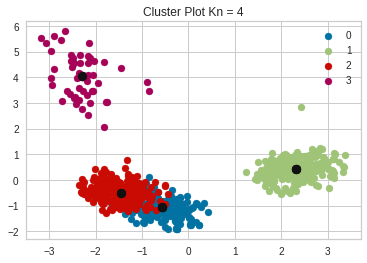

In [ ]:
#Function to visualize the clusters using pca
#PCA is done inside the visualize_clusters function (Refer to the section FUNCTIONS
#to see how this was implemented)

visualize_clusters(ALB_scaled_k4_df, 5, 4)

Notice Segment 1 (Green) and Segment 3 (Wine Color). The 2 segments are not separated, in fact they are one next to the other. The separation between these 2 segments isn't very clear.

**K=2 Clusters**

In [ ]:
# let's take 4 as number of clusters
kmeans_k2 = KMeans(n_clusters=2, random_state=1)
kmeans_k2.fit(ALB_scaled_k2_df)
prediction_k2 = kmeans_k2.predict(ALB_scaled_k2_df)

<IPython.core.display.Javascript object>

In [ ]:
# adding kmeans cluster labels to the original and scaled dataframes
ALB_k2_df["SEGMENT"] = prediction_k2
ALB_scaled_k2_df["SEGMENT"] = prediction_k2
print("SEGMENTS Assigned : \n")
ALB_k2_df.head(20)

<IPython.core.display.Javascript object>

SEGMENTS Assigned : 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,SEGMENT
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,0
5,20000,3,0,1,8,1
6,100000,5,0,11,2,0
7,15000,3,0,1,1,1
8,5000,2,0,2,2,1
9,3000,4,0,1,7,1


In [ ]:
cluster_profile_k2 = ALB_k2_df.groupby("SEGMENT").mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

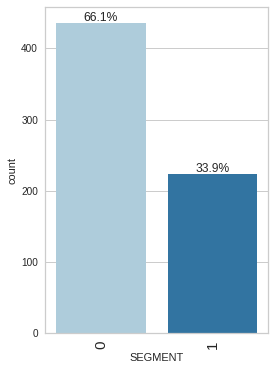

In [ ]:
#plot counts for each segment
labeled_barplot(ALB_scaled_k2_df, "SEGMENT", perc=True, n=None)

In [ ]:
# let's display cluster profiles
cluster_profile_k2.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
SEGMENT,,,,,
0,46082.568807,5.885321,3.158257,2.119266,1.894495
1,12174.107143,2.410714,0.933036,3.553571,6.870536


In [ ]:
cluster_profile_k2["count_in_each_segments"] = (
    ALB_k2_df.groupby("SEGMENT")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

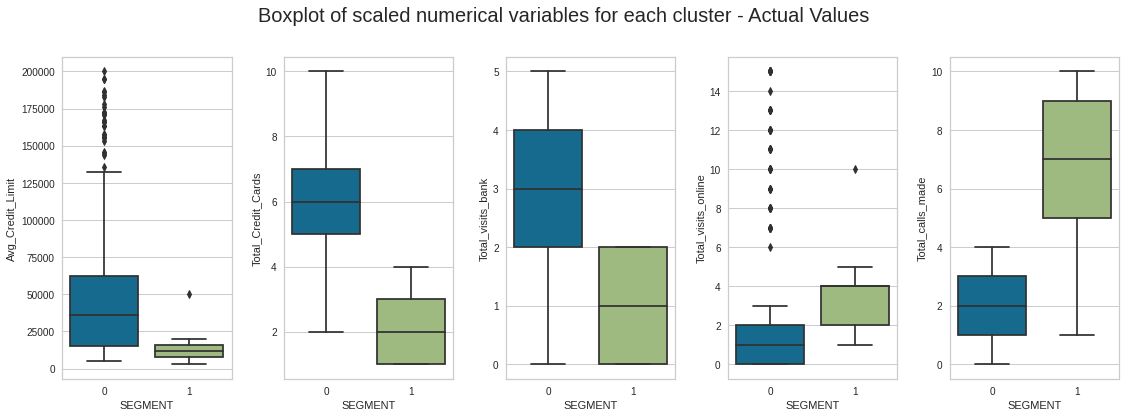

In [ ]:
#visualize the boxplots for each segment and feature
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster - Actual Values", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ALB_k2_df[num_col[counter]],
        x=ALB_k2_df["SEGMENT"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [ ]:
#Crosstable Total_Credit_cards per segment
pd.crosstab(ALB_k2_df.SEGMENT, ALB_k2_df.Total_Credit_Cards).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_Credit_Cards,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,
0,0,1,0,102,74,117,101,11,11,19
1,59,63,53,49,0,0,0,0,0,0


Overall the separation is good.

In [ ]:
#Crosstable Avg_Credit_Limt per segment
pd.crosstab(ALB_k2_df.Avg_Credit_Limit,ALB_k2_df.SEGMENT).style.highlight_max(
    color="darkgreen", axis=1)

<IPython.core.display.Javascript object>

SEGMENT,0,1
Avg_Credit_Limit,,
3000,0,1
5000,8,13
6000,14,17
7000,11,13
8000,15,20
9000,10,18
10000,12,14
11000,9,15
12000,10,8


Overall the separation is good.

In [ ]:
#Crosstable Total_Visits_bank per segment
pd.crosstab(ALB_k2_df.SEGMENT, ALB_k2_df.Total_visits_bank).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_bank,0,1,2,3,4,5
SEGMENT,,,,,,
0,20,33,93,100,92,98
1,80,79,65,0,0,0


The separation between segment 0 and 1 good.

In [ ]:
#Crosstable Total_visits_online per segment
pd.crosstab(ALB_k2_df.SEGMENT, ALB_k2_df.Total_visits_online).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_visits_online,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
SEGMENT,,,,,,,,,,,,,,,,
0,144,106,135,1,0,0,1,7,6,4,5,5,6,5,1,10
1,0,3,54,43,69,54,0,0,0,0,1,0,0,0,0,0


Separation between Segments is not clear.

In [ ]:
#Crosstable Total_calls_made per segment
pd.crosstab(ALB_k2_df.SEGMENT, ALB_k2_df.Total_calls_made).style.highlight_max(
    color="darkgreen", axis=0
)

<IPython.core.display.Javascript object>

Total_calls_made,0,1,2,3,4,5,6,7,8,9,10
SEGMENT,,,,,,,,,,,
0,97,89,90,83,77,0,0,0,0,0,0
1,0,1,1,0,31,29,39,35,30,32,26


Separation between segments is good.

Visualization of Clusters k=2

<IPython.core.display.Javascript object>

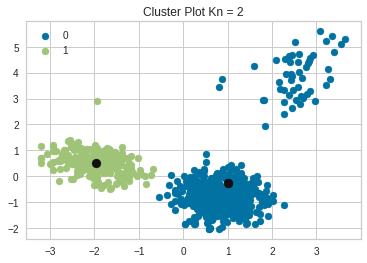

In [ ]:
#Function to visualize the clusters using pca
#PCA is done inside the visualize_clusters function (Refer to the section FUNCTIONS
#to see how this was implemented)

visualize_clusters(ALB_scaled_k2_df, 5, 2)

Notice that K=2 clusters is good except that there is a large group of data points that are too far from the center of the segment 0. Therefore, this doesn't look better than K=3.

Comparing K=2, K=3, K=4.

Earlier, we compared the silhouette scores and determined:

- n_clusters = 2, silhouette score = 0.41842496663215445
- n_clusters = 3, silhouette score = 0.5157182558881063
- n_clusters = 4, silhouette score = 0.3556670619372605

So n_clusters - 3 has the highest score.

**Revisit the Silhouete Visualizations for K=2,K=3,K=4.**

<IPython.core.display.Javascript object>

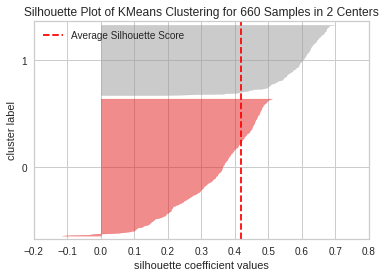

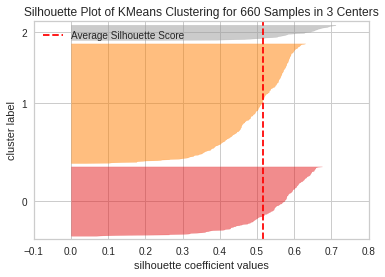

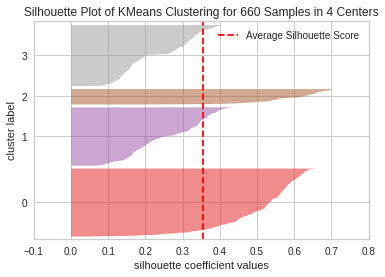

In [ ]:
#make subplots

kns = [2,3,4]

for kn in kns:
  visualizer=SilhouetteVisualizer(KMeans(kn, random_state=1))
  visualizer.fit(ALB_scaled_df)
  visualizer.show()

As we stated earlier, the silhouete score for K=3 is the highest. Also from the silhouette visualizations, we can determine that for K=3, the 3 clusters are more balanced than for K=2 and K=4.

Now lets compare the K=2, K=3, and K=4 clusters.

<IPython.core.display.Javascript object>

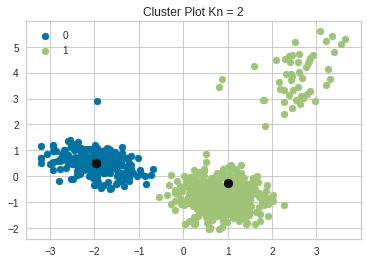

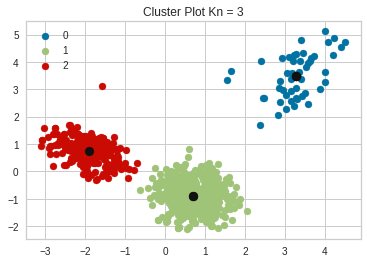

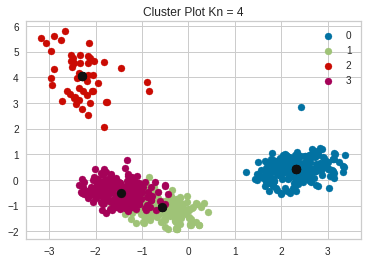

In [ ]:
#Function to visualize the clusters using pca
#PCA is done inside the visualize_clusters function (Refer to the section FUNCTIONS
#to see how this was implemented)
visualize_clusters(ALB_scaled_k2_df, 5, 2)
visualize_clusters(ALB_scaled_k3_df, 5, 3)
visualize_clusters(ALB_scaled_k4_df, 5, 4)


### **Conclusions for Kn means Clustering**


From the above cluster plots, we can determine that when k=3, the clustering is best.

With all the information above, we determined that for Kn means, K=3 is the best number of clusters.

## **Hierarchical Clustering**

Next we will apply Hierarchical clustering with different linkage methods, plots the corresponding dendograms for each linkage method, check the cophenetic correlations for each linkage method and determine the appropriate number of clusters.

In [ ]:
#We are going to implement the model with the following distances and linkage methods.
distance_metrics = ["euclidean","chebyshev","cityblock","mahalanobis"]
linkage_methods = ["single","complete","average","weighted"]
linkage_methods_Eu = ["ward", "centroid"]

<IPython.core.display.Javascript object>

### **Cophenetic** Correlation

In [ ]:
#Determine the cophenetic correlation for different distances and linkage methods
high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(ALB_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(ALB_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

<IPython.core.display.Javascript object>

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Cityblock distance and single linkage is 0.7252379350252723.
Cophenetic correlation for Cityblock distance and complete linkage is 0.8731477899179829.
Cophenetic correlation for Cityblock distance and average linkage is 0.896329431104133.
Cophenetic correlati

In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

<IPython.core.display.Javascript object>

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


Since Euclidean distance gave the highest Correlation, we will first focus on this distance only.

In [ ]:
# list of linkage methods
linkage_methods_Euclidean = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods_Euclidean:
    Z = linkage(ALB_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(ALB_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm


<IPython.core.display.Javascript object>

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [ ]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

<IPython.core.display.Javascript object>

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


The largest Cophenetic correlation is 0.89744 which is obtained with the Euclidean distance and average Linkage.

### **Dendrograms**

<IPython.core.display.Javascript object>

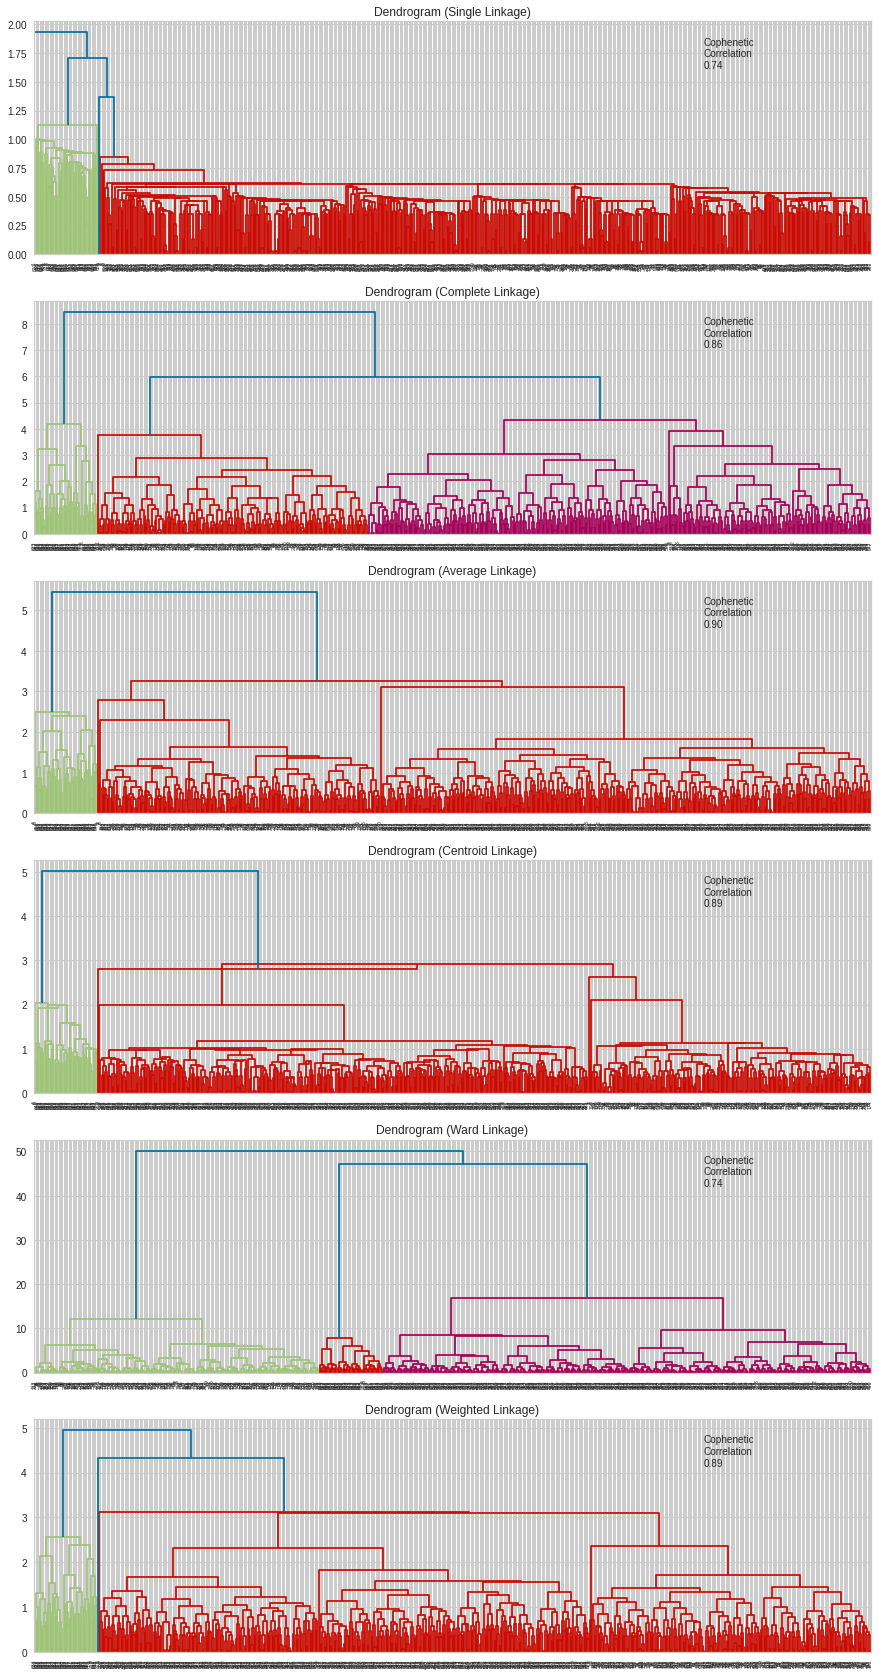

In [ ]:
# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods_Euclidean), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods_Euclidean):
    Z = linkage(ALB_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(ALB_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

To determine the number of clusters from the dendrograms, we locate the largest vertical difference between nodes and we draw a horizontal line in between. Then we count the number of intersecting vertical lines. This number is the number of clusters.

However, this not necessarily means that this is the optimal number of clusters because the threshold where the phenom line cuts the dendrogram is not a only-one-answer value.

Therefore we will use it with some reservation.

[Where to cut the dendrogram](https://www.displayr.com/what-is-dendrogram/)


In [ ]:
#let's create a dataframe to compare cophenetic correlations for each linkage method
#Euclidean Distance
coph_link = pd.DataFrame(compare, columns=compare_cols)
coph_link

<IPython.core.display.Javascript object>

,Linkage,Cophenetic Coefficient
0,single,0.739
1,complete,0.860
2,average,0.898
3,centroid,0.894
4,ward,0.742
5,weighted,0.886


As we found out earlier, the average euclidean method-distance had the highest cophenetic correlation. Second highest was the centroid-euclidean and then the weighted-euclidean.

**Dendrograms with phenom Line**

<IPython.core.display.Javascript object>

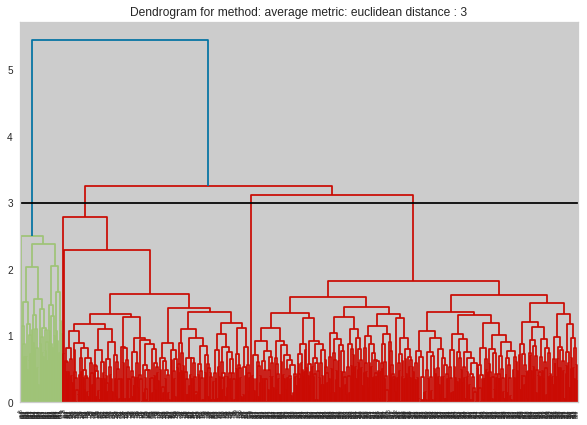

In [ ]:
#plot the dendrograms with a phenom line, from before notice distance is somewhere in betweem
#distance 5 to 3. If we choose 3:
dendrogram_single_plot(ALB_scaled_df,"average","euclidean",3)

If we choose the phenom line at distance = 3, then we obtain 4 clusters.

<IPython.core.display.Javascript object>

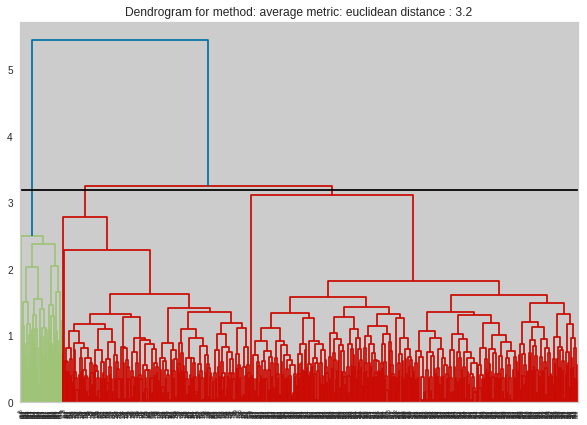

In [ ]:
#plot the dendrograms with a phenom line, from before notice distance is somewhere in betweem
#distance 5 to 3. If we choose 3.2:
dendrogram_single_plot(ALB_scaled_df,"average","euclidean",3.2)

In the case above, the number of clusters is 3.

So from the above it is clear that a dendrogram can only give us an idea of what the optimal number of clusters should be.

<IPython.core.display.Javascript object>

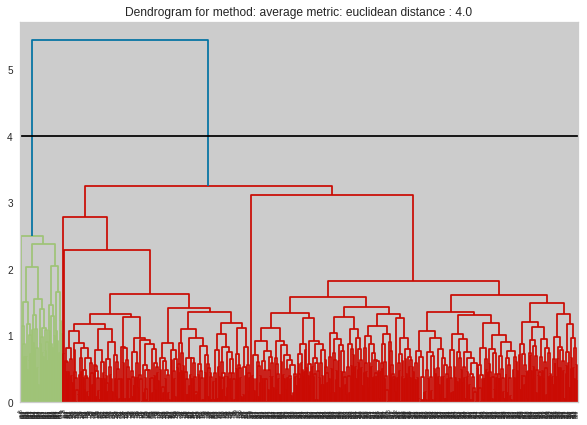

In [ ]:
#plot the dendrograms with a phenom line, from before notice distance is somewhere in betweem
#distance 5 to 3. If we choose 4.0:
dendrogram_single_plot(ALB_scaled_df,"average","euclidean",4.0)

If we chose the distance to be 4, the number of clusters would be 2.

So what is the optimal number of clusters considering the Average-Euclidean method-distance?

From the plots above we can see that somewhere between 2 and up to 5 clusters.

Lets plot the other dendrograms for the other methods with Euclidean distance.

<IPython.core.display.Javascript object>

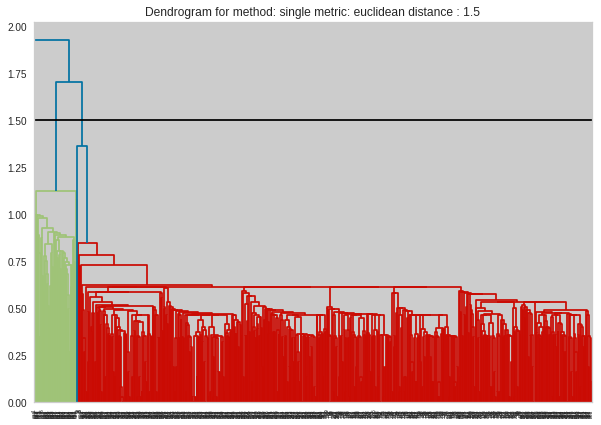

In [ ]:
#plot dendrogram with phenom line for Single Euclidean, from before notice distance is somewhere
#between 2 and 1.15,
dendrogram_single_plot(ALB_scaled_df,"single","euclidean",1.5)

The phenom line determines that the optimal number of clusters is 3.

<IPython.core.display.Javascript object>

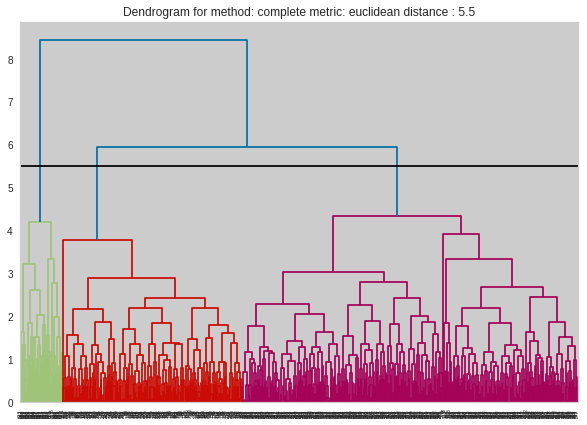

In [ ]:
#plot dendrogram with phenom line for Complete Euclidean, from before notice distance lets consider
#distance to be 5.5
dendrogram_single_plot(ALB_scaled_df,"complete","euclidean",5.5)

If we picked the distance to be 5.5 we would note 3 clusters.

<IPython.core.display.Javascript object>

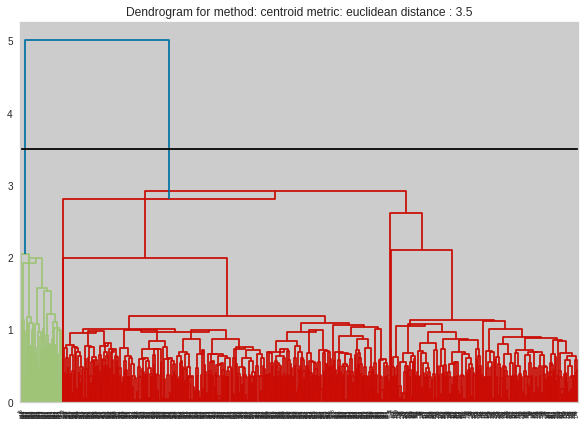

In [ ]:
#plot dendrogram with phenom line for Centroid Euclidean, from before notice distance
#lets take 3.5
dendrogram_single_plot(ALB_scaled_df,"centroid","euclidean",3.5)

When we chose the distance to be 3.5, the centroid-Euclidean method-distance resulted in 2 clusters.

The number of clusters could have also fluctuated between 2 to 5.

<IPython.core.display.Javascript object>

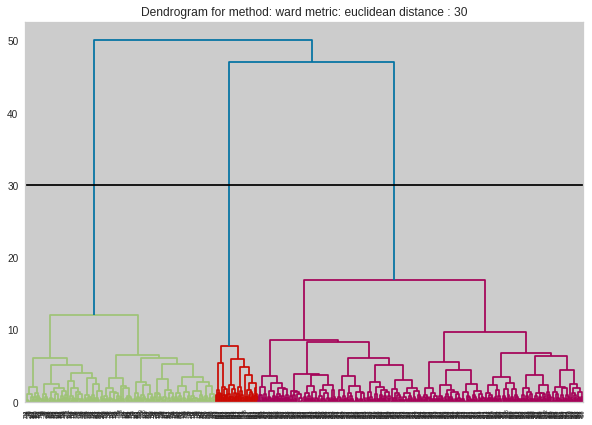

In [ ]:
#plot dendrogram with phenom line for Ward Euclidean, from before notice distance
#lets consider 30
dendrogram_single_plot(ALB_scaled_df,"ward","euclidean",30)

When we chose the distance to be 30, we noted 3 clusters.

<IPython.core.display.Javascript object>

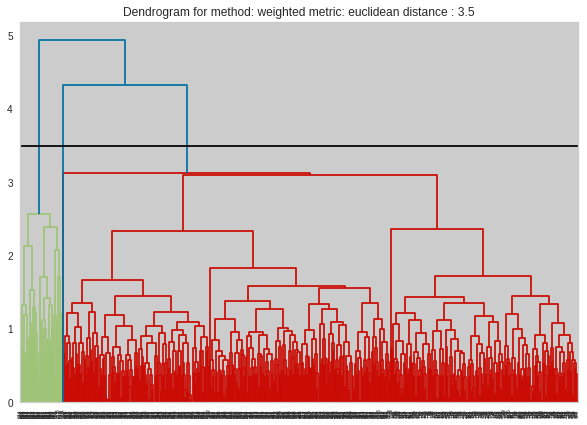

In [ ]:
#plot dendrogram with phenom line for Weighted Euclidean, from before notice distance
#lets consider distance 3.5
dendrogram_single_plot(ALB_scaled_df,"weighted","euclidean",3.5)

When we chose distance to be 3.5 we noted 3 clusters.

We already knew that the highest cophenetic correlation value was obtained with Euclidean-average distance-method.

When we focused on this, we noticed that the number of clusters could be anywhere between

The highest was cophenetic correlation value was given by Euclidean Average.

1. Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.

Then it was these methods-distances:

2. Cophenetic correlation for Cityblock distance and average linkage is 0.896329431104133.

3. Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.

4. Cophenetic correlation for Euclidean and centroid linkage is 0.8939385846326323.

5. Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.

6. Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.

7. Cophenetic correlation for Cityblock distance and weighted linkage is 0.8825520731498188.

8. Cophenetic correlation for Cityblock distance and complete linkage is 0.8731477899179829.

9. Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.

10. Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.

11. Cophenetic correlation for Euclidean distance and ward linkage is 0.7415156284827493.

12. Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.

We already saw the Euclidean distance with all methods. Now lets take a look at the next 3 methods-distances because they are around 0.89xx value, close to what was obtained with the average Euclidean method:

- Cityblock-Average
- Chebyshev-Average
- Euclidean-Centroid (already seen above)

Also notice that Mahalanobis distance gave the lowest cophenetic correlation values.



<IPython.core.display.Javascript object>

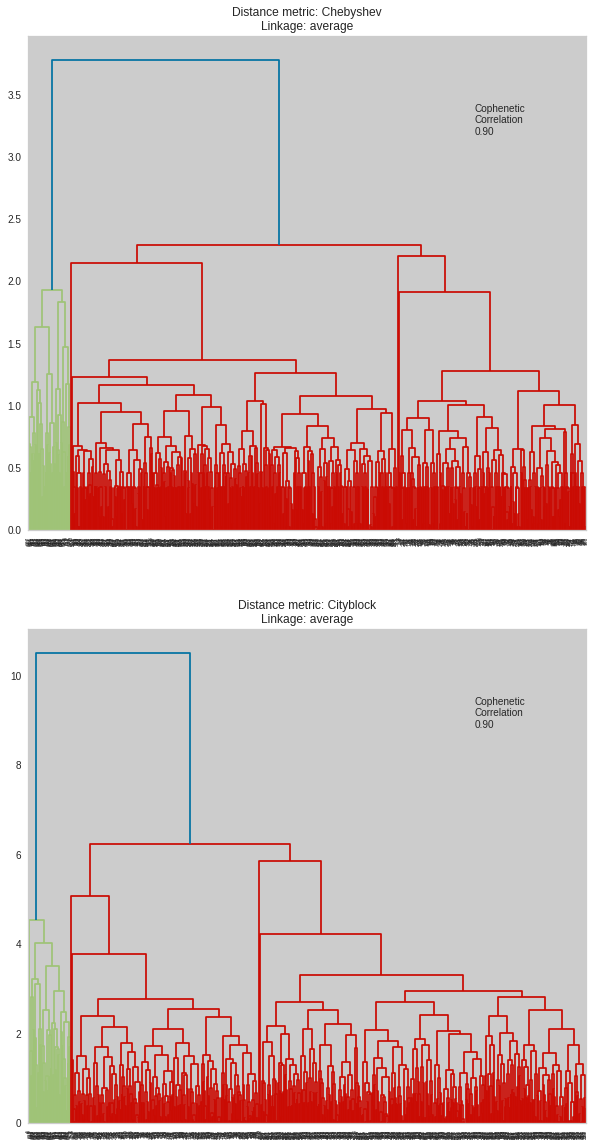

In [ ]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# list of linkage methods
linkage_methods = ["average"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics), figsize=(10, 20)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(ALB_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(ALB_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

Next we run phenom lines in the above distance-method dendrograms.

<IPython.core.display.Javascript object>

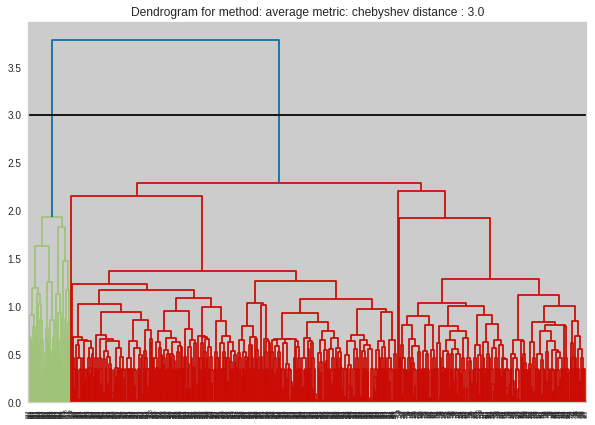

In [ ]:
#plot dendrogram with phenom line for Chebyshev Average, from before notice distance
#lets consider distance 3
dendrogram_single_plot(ALB_scaled_df,"average","chebyshev",3.0)

From the above plot we consider clusters = 2.

<IPython.core.display.Javascript object>

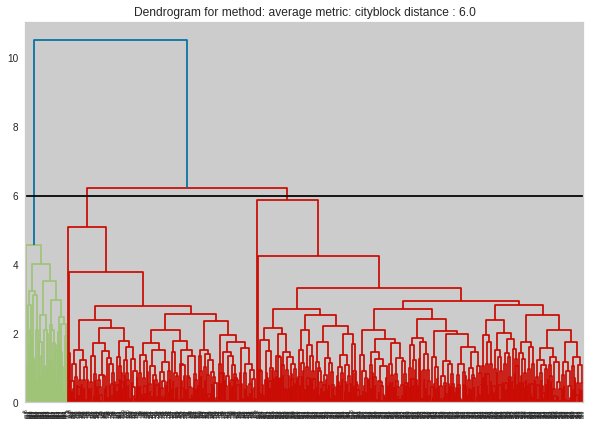

In [ ]:
#plot dendrogram with phenom line for citiblock Average, from before notice distance
#lets consider distance 6
dendrogram_single_plot(ALB_scaled_df,"average","cityblock",6.0)

From the above plot if we chose distance to be 6, we note 3 clusters.

So 3 clusters is common in all methods-distances that we analyzed.

### **Model Euclidean-Average**

Linkage: {'average'}

uses the average of the distances of each observation of the two sets.

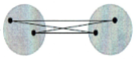

We choose clusters = 3.

In [ ]:
#copy dataframes for Hiearchical Clustering
ALB_hc_scaled_df = ALB_scaled_df.copy()
ALB_hc_df = ALB_df.copy()

<IPython.core.display.Javascript object>

In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(ALB_scaled_df)

<IPython.core.display.Javascript object>

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=3)

In [ ]:
# adding hierarchical cluster labels to the original and scaled dataframes
ALB_hc_scaled_df["SEGMENT"] = HCmodel.labels_
ALB_hc_df["SEGMENT"] = HCmodel.labels_

<IPython.core.display.Javascript object>

**Cluster Profiling**

In [ ]:
cluster_profile_avg = ALB_hc_df.groupby("SEGMENT").mean()

<IPython.core.display.Javascript object>

In [ ]:
cluster_profile_avg["segment_count"] = (
    ALB_hc_df.groupby("SEGMENT")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [ ]:
# let's display cluster profiles
cluster_profile_avg.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,segment_count
SEGMENT,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


<IPython.core.display.Javascript object>

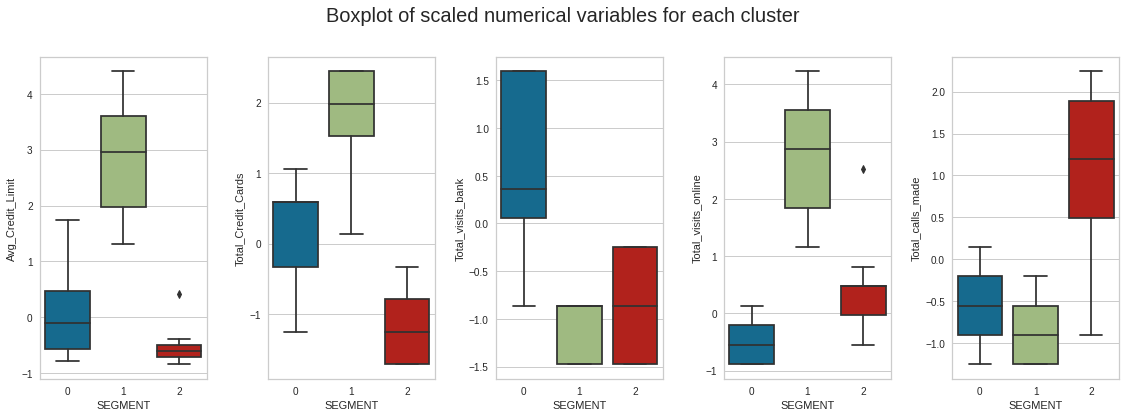

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=ALB_hc_scaled_df[num_col[counter]],
        x=ALB_hc_scaled_df["SEGMENT"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

<IPython.core.display.Javascript object>

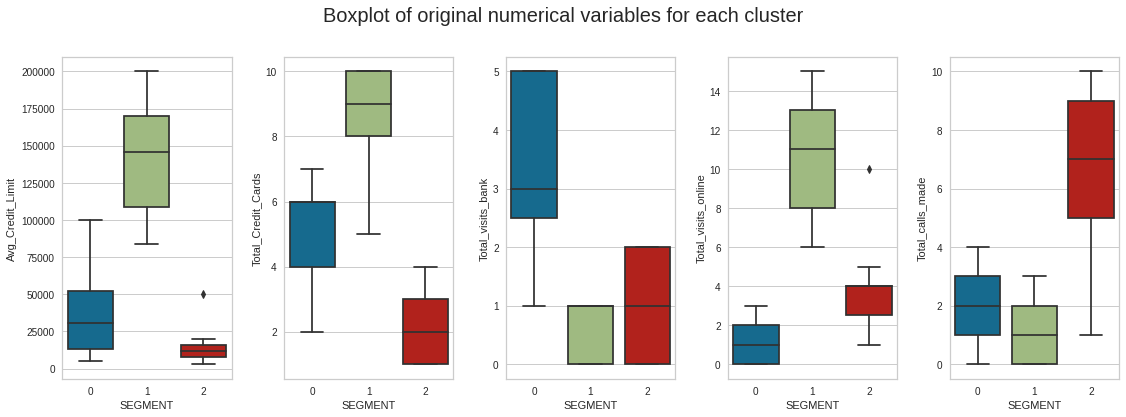

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=ALB_hc_df[num_col[counter]], x=ALB_hc_df["SEGMENT"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

Notice that Total_Credit_Cards and Total_visits_online are well separated.

Total_calls_made segment 0 and 1 is not separated well, and neither is segment 1 and 2 for Total_values_bank.

Avg_Credit_Limit is well separated for Segment 0 and 1 but not for 2.

Visualize the Clusters

<IPython.core.display.Javascript object>

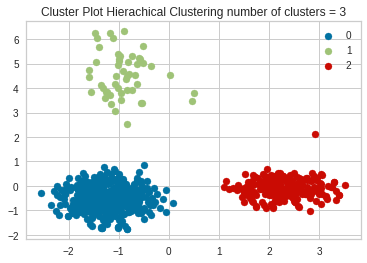

In [ ]:
visualize_hc_clusters(ALB_hc_scaled_df,5,3)

Clusters equal to 3 performed well.

<IPython.core.display.Javascript object>

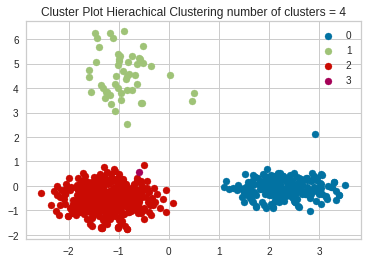

In [ ]:
visualize_hc_clusters(ALB_hc_scaled_df,5,4)

Clusters equal to 4 didn't perform well.

<IPython.core.display.Javascript object>

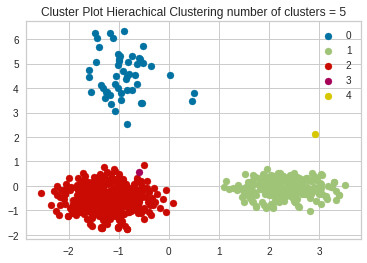

In [ ]:
visualize_hc_clusters(ALB_hc_scaled_df,5,5)

Clusters equal to 5 didn't perform well.

<IPython.core.display.Javascript object>

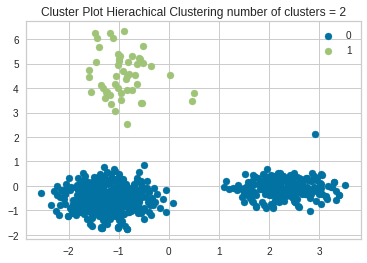

In [ ]:
visualize_hc_clusters(ALB_hc_scaled_df,5,2)

clusters equal to 2 didn't perform well at all.

**Summarizing Hierarchical Clustering**

In [ ]:
cc= [[1,'Euclidean','average',0.8977080867389372],
           [2,'Cityblock','average',0.896329431104133],
           [3,'Chebyshev','average',0.8974159511838106],
           [4,'Euclidean','centroid',0.8939385846326323]]

cc_df = pd.DataFrame(cc,columns=['Ranking','Distance','Method','Cophenetic_Value'])
cc_df

<IPython.core.display.Javascript object>

,Ranking,Distance,Method,Cophenetic_Value
0,1,Euclidean,average,0.898
1,2,Cityblock,average,0.896
2,3,Chebyshev,average,0.897
3,4,Euclidean,centroid,0.894


**Revisiting our previous dendrograms for HC**

<IPython.core.display.Javascript object>

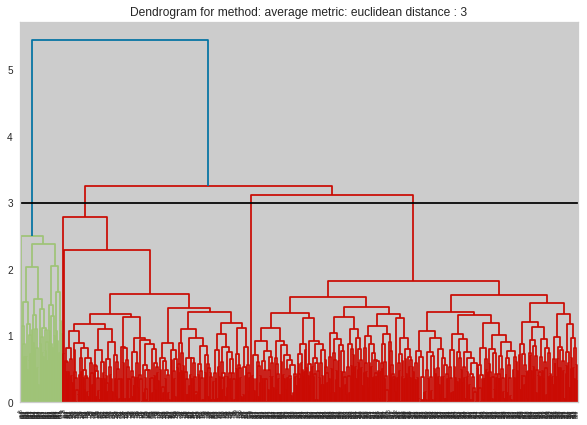

In [ ]:
#plot the dendrograms with a phenom line, from before notice distance is somewhere in betweem
#distance 5 to 3. If we choose 3:
dendrogram_single_plot(ALB_scaled_df,"average","euclidean",3)

<IPython.core.display.Javascript object>

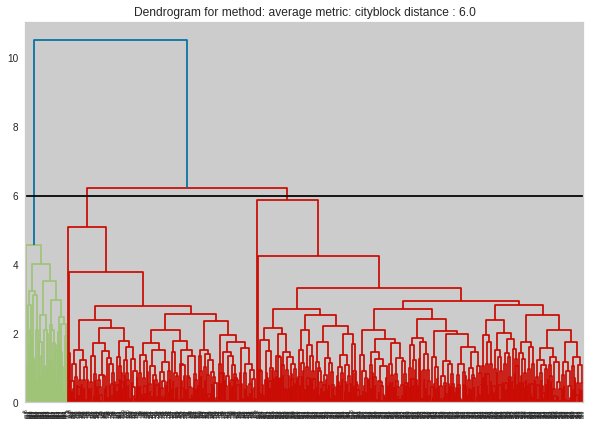

In [ ]:
#plot dendrogram with phenom line for citiblock Average, from before notice distance
#lets consider distance 6
dendrogram_single_plot(ALB_scaled_df,"average","cityblock",6.0)

<IPython.core.display.Javascript object>

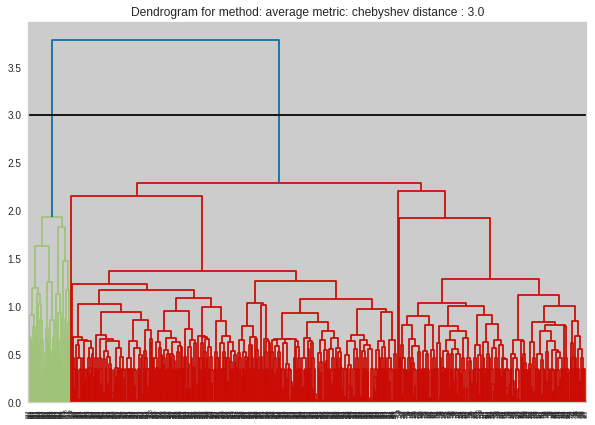

In [ ]:
#plot dendrogram with phenom line for Chebyshev Average, from before notice distance
#lets consider distance 3
dendrogram_single_plot(ALB_scaled_df,"average","chebyshev",3.0)

<IPython.core.display.Javascript object>

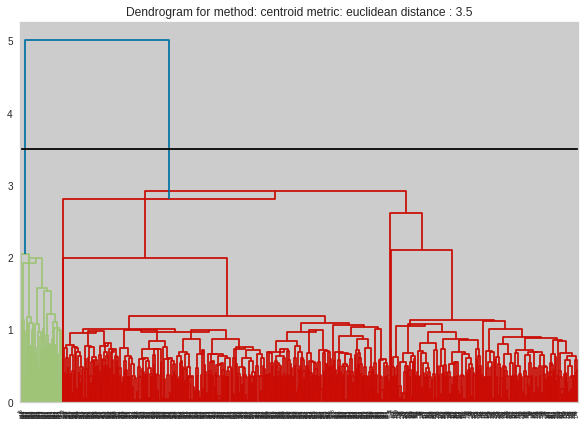

In [ ]:
#plot dendrogram with phenom line for Centroid Euclidean, from before notice distance
#lets take 3.5
dendrogram_single_plot(ALB_scaled_df,"centroid","euclidean",3.5)

We determined that for the top 3 distance-methods, cluster = 3 is within the possible values.

We also visualized the clusters and determined that 3 clusters works the best.

So in conclusion, the Hierarchical Clustering worked best with  Average linkage method, Euclidean method and 3 clusters.

## **Comparing Kn vs Hierarchical Results**

We cam compare how clustering worked in both cases.

<IPython.core.display.Javascript object>

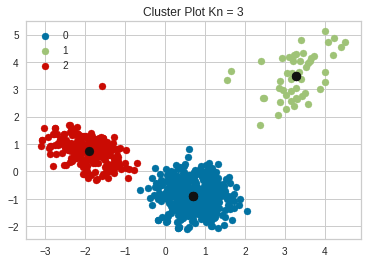

In [ ]:
visualize_clusters(ALB_scaled_k3_df, 5, 3)

<IPython.core.display.Javascript object>

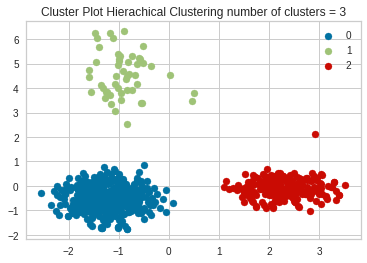

In [ ]:
visualize_hc_clusters(ALB_hc_scaled_df,5,3)

Note that athe clustering that both methods perform similarly well.

### **Compare Profiles**

**Kn means Clustering**

<IPython.core.display.Javascript object>

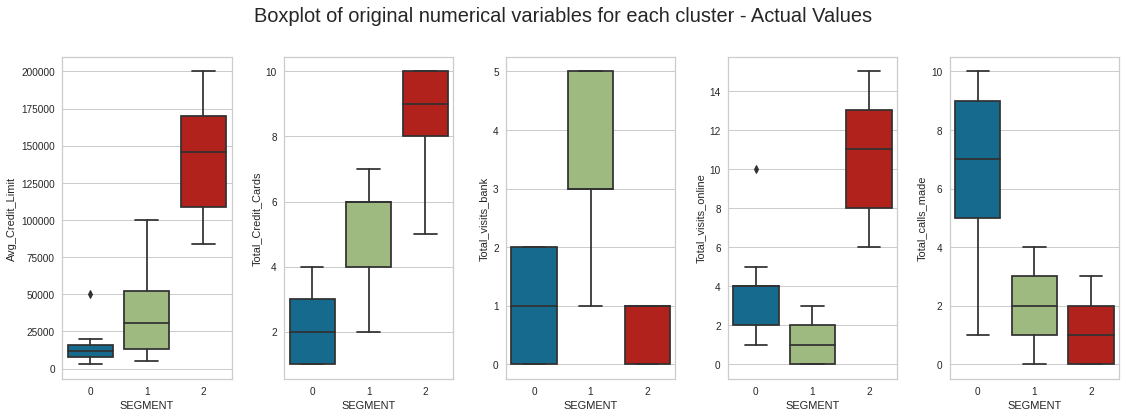

In [ ]:
#visualize the boxplots for each segment for each feature for the data represented
#with actual values.
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster - Actual Values", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=ALB_k3_df[num_col[counter]], x=ALB_k3_df["SEGMENT"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [ ]:
# let's display cluster profiles
cluster_profile_k3.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
SEGMENT,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

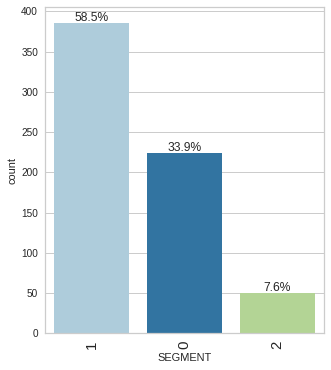

In [ ]:
#plot counts for each segment
labeled_barplot(ALB_scaled_k3_df, "SEGMENT", perc=True, n=None)

**HC Clustering**

<IPython.core.display.Javascript object>

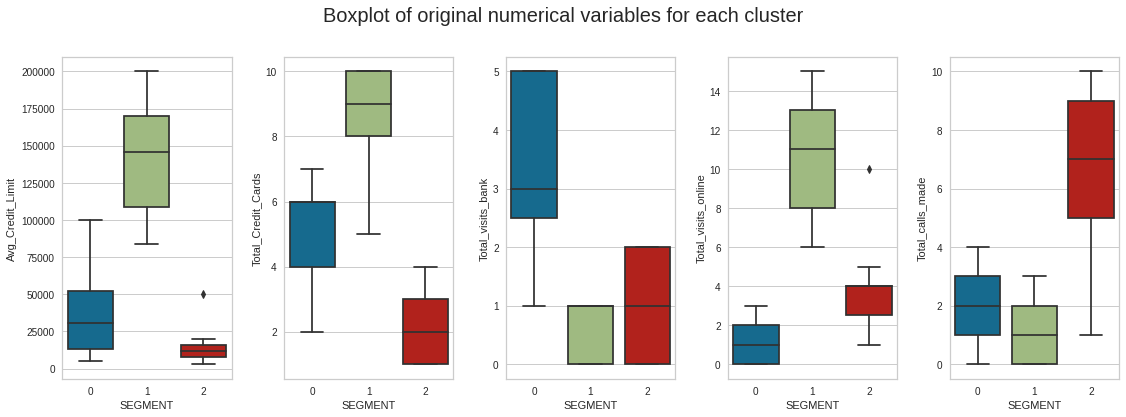

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=ALB_hc_df[num_col[counter]], x=ALB_hc_df["SEGMENT"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

In [ ]:
# let's display cluster profiles
cluster_profile_avg.style.highlight_max(color="darkgreen", axis=0)

<IPython.core.display.Javascript object>

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,segment_count
SEGMENT,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


Notice that actually there are no noticeable differences between KN and HC clustering. The segments labels may be different but the clustering is very similar.

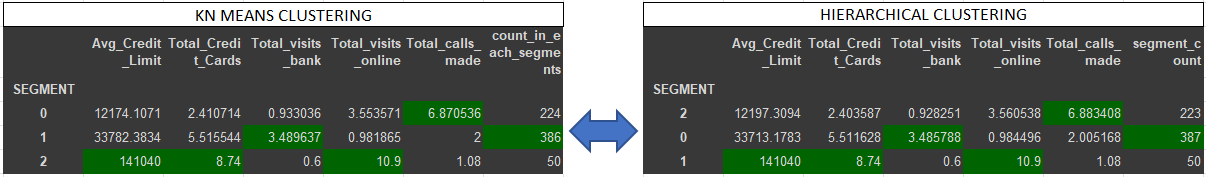

<IPython.core.display.Javascript object>

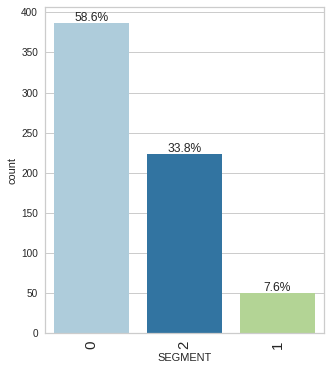

In [ ]:
#plot counts for each segment
labeled_barplot(ALB_hc_scaled_df, "SEGMENT", perc=True, n=None)

Notice that both Kn and HC cluster the dataset almost identically. There are only a slight difference between them.

We conclude that Kmeans and HC perform similarly. Both settle for 3 clusters and alt

### **Clustered Data Analysis**

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='SEGMENT', ylabel='count'>

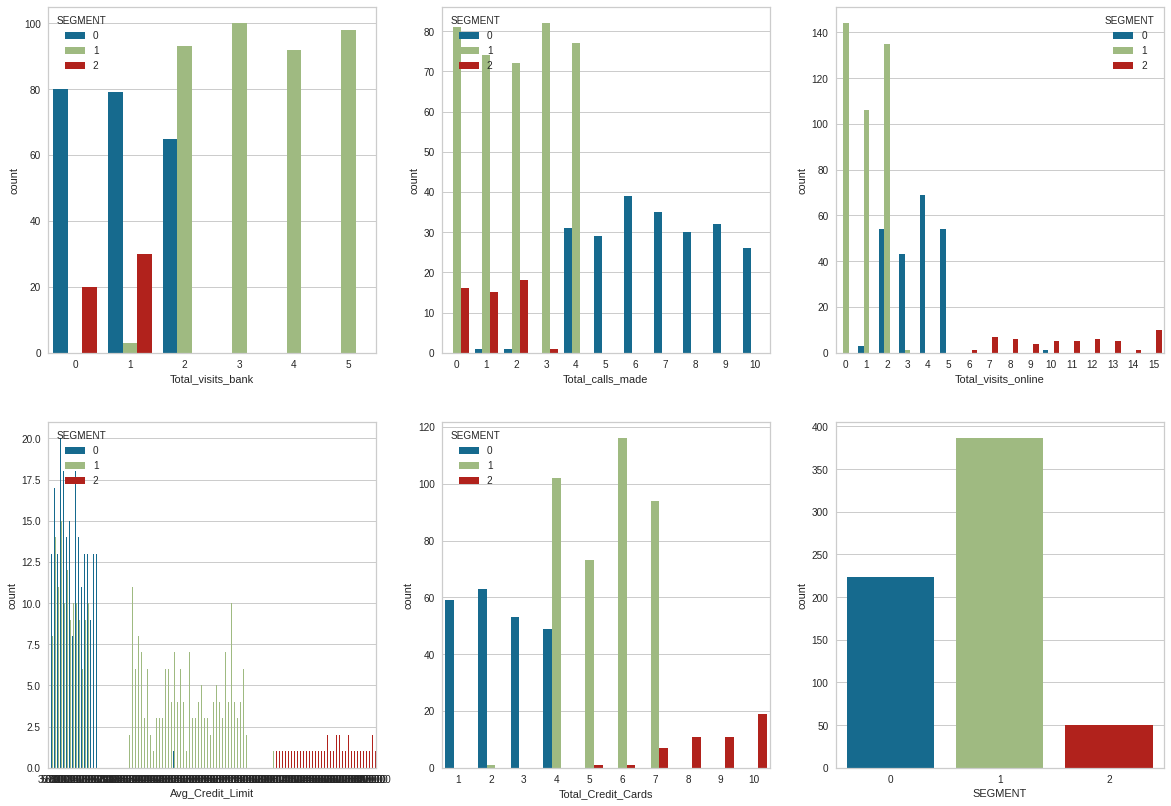

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20,14))

sns.countplot(data=ALB_k3_df, x="Total_visits_bank", hue="SEGMENT", ax=axes[0,0])
sns.countplot(data=ALB_k3_df, x="Total_calls_made", hue="SEGMENT", ax=axes[0,1])
sns.countplot(data=ALB_k3_df, x="Total_visits_online", hue="SEGMENT", ax=axes[0,2])
sns.countplot(data=ALB_k3_df, x="Avg_Credit_Limit", hue="SEGMENT",ax=axes[1,0])
sns.countplot(data=ALB_k3_df, x="Total_Credit_Cards", hue="SEGMENT",ax=axes[1,1])
sns.countplot(data = ALB_k3_df, x="SEGMENT", ax=axes[1,2])

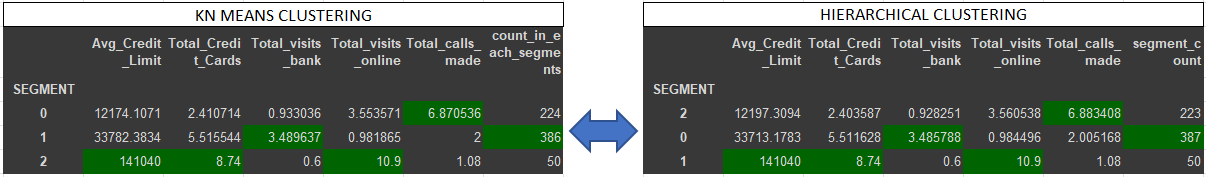

In [ ]:
#calculate the average credit limit per card.
ALB_S0_df = ALB_k3_df[ALB_k3_df['SEGMENT']==0]
ALB_S1_df = ALB_k3_df[ALB_k3_df['SEGMENT']==1]
ALB_S2_df = ALB_k3_df[ALB_k3_df['SEGMENT']==2]

#for credit limit
ACCL_S0 = ALB_S0_df['Avg_Credit_Limit'].sum()/ALB_S0_df['Total_Credit_Cards'].sum()
ACCL_S1 = ALB_S1_df['Avg_Credit_Limit'].sum()/ALB_S1_df['Total_Credit_Cards'].sum()
ACCL_S2 = ALB_S2_df['Avg_Credit_Limit'].sum()/ALB_S2_df['Total_Credit_Cards'].sum()

#for online
AOV_S0 = ALB_S0_df['Total_visits_online'].sum()/ALB_S0_df['Total_Credit_Cards'].sum()
AOV_S1 = ALB_S1_df['Total_visits_online'].sum()/ALB_S1_df['Total_Credit_Cards'].sum()
AOV_S2 = ALB_S2_df['Total_visits_online'].sum()/ALB_S2_df['Total_Credit_Cards'].sum()

#for bank visits
ABV_S0 = ALB_S0_df['Total_visits_bank'].sum()/ALB_S0_df['Total_Credit_Cards'].sum()
ABV_S1 = ALB_S1_df['Total_visits_bank'].sum()/ALB_S1_df['Total_Credit_Cards'].sum()
ABV_S2 = ALB_S2_df['Total_visits_bank'].sum()/ALB_S2_df['Total_Credit_Cards'].sum()

#for calls
ACM_S0 = ALB_S0_df['Total_calls_made'].sum()/ALB_S0_df['Total_Credit_Cards'].sum()
ACM_S1 = ALB_S1_df['Total_calls_made'].sum()/ALB_S1_df['Total_Credit_Cards'].sum()
ACM_S2 = ALB_S2_df['Total_calls_made'].sum()/ALB_S2_df['Total_Credit_Cards'].sum()




accl_k3 = [[0,ACCL_S0, AOV_S0, ABV_S0, ACM_S0],[1,ACCL_S1,AOV_S1, ABV_S1, ACM_S1],
           [2,ACCL_S2,AOV_S2, ABV_S2, ACM_S2]]
accl_k3_df = pd.DataFrame(accl_k3,columns=['SEGMENT','Avg Credit pc',
                                           'Avg Online Visit pc',
                                           'Avg Bank Visit pc',
                                           'Avg Call Made pc'])


accl_k3_df

<IPython.core.display.Javascript object>

,SEGMENT,Avg Credit pc,Avg Online Visit pc,Avg Bank Visit pc,Avg Call Made pc
0,0,5050.000,1.474,0.387,2.850
1,1,6124.941,0.178,0.633,0.363
2,2,16137.300,1.247,0.069,0.124


## **Conclusions, Insights, Takeaways**

1. ALB should classify its customers into 3 segments, namely SuperVIP (Segment 2), VIP (Segment 1), and Standard (segment 0). The names can change according to the Marketing Department plan. However, the idea is that SuperVIP are more exclusive customers, and VIP are most common customers.

2. The largest segment is the VIP segment-1 with 59% of all customers, followed by the Standard-0 segment with 34%. The SuperVIP-2 segment only has 7.6% of all customers.

**Customer Characteristics per segment**

3. The average customer of SuperVIP-2 segment, although he/she has the most total credit cards (average of 8.74 average), makes only 0.6 visits to the bank, and 1.08 calls, both the least among all groups. Predominantly it makes 10.9 visits online, by far the largest number among all segments. This customer also has the highest credit limit, more than 4 times the credit limit of the VIP-1 segment, and more than 11 times the total credit limit of the Standard-0 segment. Per credit card, it has an average credit limit of \$16,137, which is more than three times the credit limit per card for the Standard-0 segment, and about 2.6 times the credit limit per card of the VIP-1 segment.

4. The average customer of the Standard-0 segment, has 2.4 credit cards. This customer is the one that makes the most phone calls to the bank (6.9 on average). He/she makes 3.6 visits online (second only to the SuperVIP customer), and makes 0.93 visits to the bank. The standard-0 customer has the smallest total credit limit, less than half of what the VIP-1 segment has and less than 10% of what the SuperVIP-2 segment has. The average credit limit per credit card is \$5050 which is about 20% less than the credit card limit of the VIP-1 segment. However, when compared to the SuperVIP, the credit card only has less than 30% of spending power.

5. The average customer of the VIP-1 segment, has 5.5 credit cards, its credit limit is more than double the limit of the Standard-0 customer but only 24% of the limit of the SuperVIP-1 customer.  This customer doesn't go online (only 0.98 visits online per customer - the lowest among all segments), it makes twice as many more calls than SuperVIP-2 and also goes to the bank more than all other segments. The VIP-1 customer goes to the bank 3.5 times, roughly 6 more times than the SuperVIP-2 customer and 4 times more than the Standard-0 customer. Its credit card has an average spending power of \$6,100, which is 20% more than the credit card of a customer from the Standard-0 segment, but only 24% of the spending power of the SuperVIP-2.

**Customer Characteristics per segment per Card**

6. VIP-1 credit cards consistently have the more problems, inquiries, issues with their products, to the point that they average 0.63 visits to the bank per credit card. This is almost twice as many visits a Standard-0 credit card makes and about 10 times more the visits a SuperVip-2 credit card makes to the bank. The VIP-1 credit card makes the least online visits - roughly 12% of the visits compared to a Standard-0 credit card and 14% when compared to a SuperVIP-2.

7. Standard-0 credit cards make less visits to the bank than VIP-1 credit cards (roughly 40% less), but significantly more than SuperVIP-2 cards. The standard-0 credit cards are the ones that make more online visits and also the ones that make the most phone calls.

8. SuperVIP-2 cards make the least calls, the least visits and less online visits than the Standard-0 card.

This is the ranking of the Troublesome Bank Visit

From Most to Least
1. VIP-1       
2. Standard-0  
3. SuperVIP-2  

This is the ranking of the Also Troublesome Phone Call to the bank

From Most to Least
1. Standard-0
2. VIP-1
3. SuperVIP-2

This is the ranking of the most convenient Online visit:

From Most to least
1. Standard-0
2. SuperVIP-2
3. VIP-1

##**Insights**

I. The most troublesome card is the VIP-1. This customer has issues that he or she feels must be solved only in the bank. This customer doesn't seem to access online services.  This card has almost double the amount of phone calls.

II. The Standard-0 customer visits online often, and more than any other segment, but also makes significantly more calls than anyone. This may be an indication that he/she cannot have his or her issues/inquiries solved online, particularly of interest is that a card produces more phone calls than online visits.

III. The SuperVIP-1 customer doesn't visit the bank, doesn't make too many calls and seems to solve issues/inquiries online.

Earlier in our bivariate analysis we also observed these interesting details:

- Total_Credit_Cards and Total_visits_online have a correlation of 0.17, among the lowest between all features. So this may mean that without regards of the Total number of credit cards, online communications may not be trusted, or may not be working, or may not provide the service customers require.

-Total_visits_online and Total_visits_bank is surprisingly high, with a correlation of 0.55. This may mean that customers that have a high number of online visits end up visiting the bank for whatever reasons, probably because their issue, problem, transaction, etc couldn't be completed online.

With the above insights we conclude that:

- Segment-1 (VIP-1) experience the most incoveniences.
- Segment-1 (VIP-1) are not heavy Internet users
- Segment-1 (VIP-1) may be more traditional, old-fashioned customers.
- Segment-0 (Std-0) are heavy internet users.
- Segment-0 (Std-0) may be younger, milenials customers
- Segment-0 (Std-0) make more phone calls than visit online.
- Segment-0 (Std-0) issues are not often solved online, thus they make more calls than anyone else.
- Segment-2 (SuperVip-2) manage their cards online, do not visit the bank and try not to make phone calls.

##**Recommendations**

1. To improve customer satisfaction, focus first on Segment-1. Promote the use of the online platform within this segment. Make the access to the online banking more user friendly and implement brochures to distribute to this segment on how to access the online platform. Also promote the advantages and security of using the online platform.

2. Discourage the bank visits. Rather than penalizing customers that visit the bank by charging fees, promote online banking by offering discounts or a award point system for using the online platform.

3. Implement and/or improve intelligent chat bots on the online platform so customers can have their questions answered.

4. Then focus on Segment-0. Focus on expanding online services and if an online bot does not work well, have a larger team of human operators that can chat with the customers, with the objective of solving issues online and avoid the customer having to make a phone call.

5. To expand services, focus mostly on Segment-0 because this is the group with the least amount of services per head.  Diversify credit services to this segment first.

6. To attract new customers, improve online banking services first. You do not want new customers that will joing the unhappy segment. However, to expand outside customers, focus on customers that can have overall high credit limit and that are interested in having many credit services. This is because this type of customer is consistently the one that doesn't want to go the bank, doesn't want to make calls, and solves most issues - somehow - online.

##**Useful data**

- More data like Age of the customer, Gender, and Income would be very useful for classifying customers correctly.
- Background on the limitations of the Online platform would be very useful to understand why the customer opts for not using the online platform.
- Average time a phone call lasts, average waiting time and service time, a customer spends at the bank would be very useful.
- Time of the day, the customer connects to the bank online or makes a phone call.
- The type of issues the customer calls, visits the bank for, or connects online.

-- Thank You ---